# Callin Switzer
___

### 16 Jan 2020
### - Train without pruning
### - Then prune


___

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rc('font',family='Times New Roman')
from matplotlib.ticker import ScalarFormatter
import os
import pandas as pd
import time
from datetime import datetime
import sys
import seaborn as sns
import scipy.io
import subprocess
#import winsound
import pickle
import glob
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
baseDir = os.getcwd()
#dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = '/home/olivia/MothMachineLearning/dataAndFigs/Figs/'
dataOutput = '/home/olivia/MothMachineLearning/dataAndFigs/DataOutput/'
savedModels = '/home/olivia/MothMachineLearning/dataAndFigs/savedModels/'
dataDir = '/home/olivia/MothMachineLearning/dataAndFigs/PythonGeneratedData_oneTorque/'
if not os.path.exists(figDir):
    os.mkdir(figDir)

if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0] 

last run on 2020-07-22 14:54:01.246409


In [2]:
tf.__version__

'1.15.0'

In [3]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.


# Make training and test set

In [4]:
# get table names in database
con1 = sqlite3.connect(os.path.join(dataDir, "oneTorqueData.db"))
cursorObj = con1.cursor()
res = cursorObj.execute("SELECT name FROM sqlite_master WHERE type='table';")
tableNames = [name[0] for name in res]
con1.close()
print(tableNames)

['test', 'train']


In [5]:
con1 = sqlite3.connect(os.path.join(dataDir, "oneTorqueData.db"))
trainDF = pd.read_sql_query("SELECT * FROM train", con1)
testDF = pd.read_sql_query("SELECT * FROM test", con1)
con1.close()

In [6]:
# double check for repeats!
np.sum(trainDF.iloc[:, [16,17,18]].duplicated()) # 0 means no repeats

0

In [7]:
print(trainDF.shape)
trainDF.head()

(10000000, 19)


,x_0,xd_0,y_0,yd_0,theta_0,thetad_0,phi_0,phid_0,x_f,xd_f,y_f,yd_f,theta_f,thetad_f,phi_f,phid_f,F,alpha,tau0
0,0.0,1127.569064,0.0,765.895323,1.075898,11.962440,3.427385,18.462602,18.323331,716.627905,14.965420,553.784155,2.653195,147.068401,5.115222,153.187791,41181.992912,1.987846,-63216.237665
1,0.0,979.651081,0.0,-625.561275,0.306688,-5.637037,2.576453,19.788635,18.603118,878.261004,-13.758388,-732.267264,0.102441,-34.254744,2.372751,-34.214230,9062.020340,3.567122,19108.940596
2,0.0,1111.257777,0.0,-1406.672066,5.094943,16.102668,1.775724,-9.188076,19.014000,1058.629029,-25.108839,-1007.321715,2.811424,-218.672246,-0.370204,-211.787743,42727.993224,4.104033,49781.327507
3,0.0,-1438.730397,0.0,690.882986,5.034187,-3.375327,5.534301,-9.669100,-31.101504,-1501.738112,10.625933,331.290367,6.319507,141.205184,6.795796,140.443097,28953.145279,4.698031,92261.347215
4,0.0,1370.322727,0.0,-216.459775,4.186927,-16.500337,3.194818,-0.385905,27.276171,1358.779274,-4.544002,-238.613391,3.984840,-10.035763,3.181642,-0.756667,371.601599,0.668810,-40259.257246


In [8]:
# rename columns to be consistent with other code
trainDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

# rename columns to be consistent with other code
testDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [9]:
# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

testDF["Fx"] = testDF.F * np.cos(testDF.alpha)
testDF["Fy"] = testDF.F * np.sin(testDF.alpha)


In [10]:
# make dataset
X = trainDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

# make test dataset
Xtest = testDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Ytest = testDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [11]:
X.head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,3.427385,1.075898,18.323331,14.965420,5.115222,2.653195,1127.569064,765.895323,18.462602,11.962440
1,2.576453,0.306688,18.603118,-13.758388,2.372751,0.102441,979.651081,-625.561275,19.788635,-5.637037
2,1.775724,5.094943,19.014000,-25.108839,-0.370204,2.811424,1111.257777,-1406.672066,-9.188076,16.102668
3,5.534301,5.034187,-31.101504,10.625933,6.795796,6.319507,-1438.730397,690.882986,-9.669100,-3.375327
4,3.194818,4.186927,27.276171,-4.544002,3.181642,3.984840,1370.322727,-216.459775,-0.385905,-16.500337


In [12]:
Y.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,-16681.383440,37652.197635,-63216.237665,716.627905,553.784155,153.187791,147.068401
1,-8253.874132,-3740.825371,19108.940596,878.261004,-732.267264,-34.214230,-34.254744
2,-24419.876370,-35062.102662,49781.327507,1058.629029,-1007.321715,-211.787743,-218.672246
3,-415.702991,-28950.160838,92261.347215,-1501.738112,331.290367,140.443097,141.205184
4,291.543841,230.412537,-40259.257246,1358.779274,-238.613391,-0.756667,-10.035763


In [13]:
# val train split
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [14]:
# scale data 
scalerX = MinMaxScaler([-0.5, 0.5])  
scalerY = MinMaxScaler([-0.5, 0.5])  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xval_scaled = scalerX.transform(Xval)
Yval_scaled = scalerY.transform(Yval)


# final test data
Xtest_scaled = scalerX.transform(Xtest)

In [15]:
pd.DataFrame(Xtrain_scaled, columns = X.columns).head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,0.440808,-0.497541,-0.376881,-0.092528,0.279106,-0.125546,-0.413733,-0.087276,0.151751,-0.419563
1,0.002656,0.450960,0.232234,0.301146,-0.030380,0.180345,0.276074,0.383212,0.227138,0.094672
2,0.302116,0.217276,0.364791,-0.175444,-0.008066,-0.047502,0.385703,-0.188919,-0.266187,-0.202705
3,-0.471247,0.121804,0.070077,0.310735,-0.319397,-0.062783,0.103501,0.332100,-0.227711,0.447327
4,-0.350056,-0.349031,0.313582,0.159721,-0.093290,-0.092005,0.350805,0.216431,0.136925,0.270457


# Keras models

In [16]:
# import
#from tensorflow import keras

from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
#from keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Keras callcacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

K.clear_session()

In [30]:
# create network
def create_network(optimizer = 'rmsprop', 
                    numUnits = [400, 16], 
                    weightRegularization = 0.0, 
                    dropout_rate=0.1):
    
    '''
    Create a feed forward network.  Assumes Xtrain & Ytrain have been created and scaled
    
    Params: 
    optimizer (str): choice of optimizer
    numUnits (list): number of units in each hidden
    weightRegularization (float): between 0 and 1
    dropout_rate (float): between 0 and 1
    
    '''
    K.clear_session()
    inputs = Input(shape=(Xtrain_scaled.shape[1],))    
    
    # add layers
    for ii in np.arange(0, len(numUnits)):
        if ii >= 1: 
            x = Dense(numUnits[ii], activation='tanh', 
                      kernel_regularizer=regularizers.l1(weightRegularization),use_bias=True)(x)

        else: 
            x = Dense(numUnits[ii], activation='tanh',use_bias=True)(inputs)


        # add dropout
        if dropout_rate > 0: 
            x = Dropout(dropout_rate)(x)
    
    predictions = Dense(Ytrain_scaled.shape[1], activation='linear',use_bias=True)(x)

    # create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])

    return(model)

In [159]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

# Adjusting early stop from 0.000001 to 0.0001 to try to make my plot look more like Callin's 
earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=50, 
                          verbose=1, mode='auto', min_delta = 0.000001)

In [147]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history.history['val_mean_squared_error'][-1])))
    axs.set_ylabel('Mean squared error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(0,len(model_history.history['val_mean_squared_error']), 50), 50)
    axs.legend(['train', 'validation'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + ".pdf"), dpi = 500, bbox_inches='tight')
    
    plt.show()

    
def plot_model_history_fromDict(model_history_dictionary, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(16,8))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history_dictionary['mean_squared_error'])+1),
             model_history_dictionary['mean_squared_error'])
    axs.plot(range(1,len(model_history_dictionary['val_mean_squared_error'])+1),
             model_history_dictionary['val_mean_squared_error'], alpha = 0.7)
    axs.set_title('Model MSE = '+ str(format_e(model_history_dictionary['val_mean_squared_error'][-1])))
    axs.set_ylabel('Mean squared error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(0,len(model_history_dictionary['val_mean_squared_error']), 50),50)
    axs.legend(['train', 'validation'], loc=2)
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"), dpi = 120, bbox_inches='tight')
        print(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"))


___

In [20]:
# train and trim weights

In [31]:

K.clear_session()

modelParams = {"optimizer": "rmsprop", 
              "dropout_rate" : 0, 
               "numUnits": [400, 400, 400, 16],
               "weightRegularization": 0
              }


model = create_network(**modelParams)

modeltimestamp = datetime.now().strftime("%Y_%m_%d__%I_%M_%S")
modelName = ''.join('{}_{}__'.format(key[0:3].capitalize(), val) for  key, val in modelParams.items()).\
                            replace("[", "").replace("]", "").replace(", ", "_")[0:-2] + "_" + modeltimestamp
print(modelName)

model.summary()

Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_07_23__09_04_49
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 400)               4400      
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 16)                6416      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 119       
Total params: 331,735
Trainable params: 331,735
Non-trainabl

In [32]:
model

In [33]:
# # save scalers, to be used on test set
scalerfileX = 'scalerX_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

scalerfileY = 'scalerY_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

In [34]:
# start training
historyDict = {"mean_squared_error": [], 
               "val_mean_squared_error": []}

In [35]:
# train without pruning
history = model.fit(Xtrain_scaled, Ytrain_scaled, 
                    validation_data=(Xval_scaled, Yval_scaled), 
                    callbacks = [earlystop],
                    verbose = 2, batch_size=2**12, epochs = 2000)

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/2000
8000000/8000000 - 20s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 2/2000
8000000/8000000 - 20s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 3/2000
8000000/8000000 - 20s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 4/2000
8000000/8000000 - 20s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 5/2000
8000000/8000000 - 20s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 6/2000
8000000/8000000 - 20s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 7/2000
8000000/8000000 - 20s - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 8/2000
8000000/8000000 

Epoch 60/2000
8000000/8000000 - 20s - loss: 7.2271e-04 - mean_squared_error: 7.2271e-04 - val_loss: 9.1335e-04 - val_mean_squared_error: 9.1335e-04
Epoch 61/2000
8000000/8000000 - 20s - loss: 7.1763e-04 - mean_squared_error: 7.1763e-04 - val_loss: 7.4373e-04 - val_mean_squared_error: 7.4373e-04
Epoch 62/2000
8000000/8000000 - 20s - loss: 7.1295e-04 - mean_squared_error: 7.1295e-04 - val_loss: 8.4247e-04 - val_mean_squared_error: 8.4247e-04
Epoch 63/2000
8000000/8000000 - 20s - loss: 7.0704e-04 - mean_squared_error: 7.0704e-04 - val_loss: 7.7803e-04 - val_mean_squared_error: 7.7803e-04
Epoch 64/2000
8000000/8000000 - 20s - loss: 7.0318e-04 - mean_squared_error: 7.0318e-04 - val_loss: 6.4628e-04 - val_mean_squared_error: 6.4628e-04
Epoch 65/2000
8000000/8000000 - 20s - loss: 6.9774e-04 - mean_squared_error: 6.9774e-04 - val_loss: 9.0801e-04 - val_mean_squared_error: 9.0801e-04
Epoch 66/2000
8000000/8000000 - 20s - loss: 6.9275e-04 - mean_squared_error: 6.9275e-04 - val_loss: 7.5337e-04 -

Epoch 117/2000
8000000/8000000 - 20s - loss: 5.4471e-04 - mean_squared_error: 5.4471e-04 - val_loss: 5.6026e-04 - val_mean_squared_error: 5.6026e-04
Epoch 118/2000
8000000/8000000 - 20s - loss: 5.4259e-04 - mean_squared_error: 5.4259e-04 - val_loss: 6.2119e-04 - val_mean_squared_error: 6.2119e-04
Epoch 119/2000
8000000/8000000 - 20s - loss: 5.4113e-04 - mean_squared_error: 5.4113e-04 - val_loss: 5.0240e-04 - val_mean_squared_error: 5.0240e-04
Epoch 120/2000
8000000/8000000 - 20s - loss: 5.3887e-04 - mean_squared_error: 5.3887e-04 - val_loss: 6.6616e-04 - val_mean_squared_error: 6.6616e-04
Epoch 121/2000
8000000/8000000 - 20s - loss: 5.3744e-04 - mean_squared_error: 5.3744e-04 - val_loss: 4.9017e-04 - val_mean_squared_error: 4.9017e-04
Epoch 122/2000
8000000/8000000 - 20s - loss: 5.3541e-04 - mean_squared_error: 5.3541e-04 - val_loss: 6.4335e-04 - val_mean_squared_error: 6.4335e-04
Epoch 123/2000
8000000/8000000 - 20s - loss: 5.3365e-04 - mean_squared_error: 5.3365e-04 - val_loss: 6.669

Epoch 172/2000
8000000/8000000 - 20s - loss: 4.7128e-04 - mean_squared_error: 4.7128e-04 - val_loss: 3.8745e-04 - val_mean_squared_error: 3.8745e-04
Epoch 173/2000
8000000/8000000 - 20s - loss: 4.7066e-04 - mean_squared_error: 4.7066e-04 - val_loss: 5.3380e-04 - val_mean_squared_error: 5.3380e-04
Epoch 174/2000
8000000/8000000 - 20s - loss: 4.6920e-04 - mean_squared_error: 4.6921e-04 - val_loss: 5.7162e-04 - val_mean_squared_error: 5.7162e-04
Epoch 175/2000
8000000/8000000 - 20s - loss: 4.6853e-04 - mean_squared_error: 4.6853e-04 - val_loss: 5.4367e-04 - val_mean_squared_error: 5.4367e-04
Epoch 176/2000
8000000/8000000 - 20s - loss: 4.6803e-04 - mean_squared_error: 4.6803e-04 - val_loss: 4.2356e-04 - val_mean_squared_error: 4.2356e-04
Epoch 177/2000
8000000/8000000 - 20s - loss: 4.6655e-04 - mean_squared_error: 4.6655e-04 - val_loss: 4.4477e-04 - val_mean_squared_error: 4.4477e-04
Epoch 178/2000
8000000/8000000 - 20s - loss: 4.6625e-04 - mean_squared_error: 4.6625e-04 - val_loss: 5.673

Epoch 227/2000
8000000/8000000 - 20s - loss: 4.3167e-04 - mean_squared_error: 4.3167e-04 - val_loss: 6.1827e-04 - val_mean_squared_error: 6.1827e-04
Epoch 228/2000
8000000/8000000 - 20s - loss: 4.3063e-04 - mean_squared_error: 4.3063e-04 - val_loss: 4.2998e-04 - val_mean_squared_error: 4.2998e-04
Epoch 229/2000
8000000/8000000 - 20s - loss: 4.3038e-04 - mean_squared_error: 4.3038e-04 - val_loss: 3.5383e-04 - val_mean_squared_error: 3.5383e-04
Epoch 230/2000
8000000/8000000 - 20s - loss: 4.2980e-04 - mean_squared_error: 4.2980e-04 - val_loss: 3.6556e-04 - val_mean_squared_error: 3.6556e-04
Epoch 231/2000
8000000/8000000 - 20s - loss: 4.2872e-04 - mean_squared_error: 4.2872e-04 - val_loss: 4.5501e-04 - val_mean_squared_error: 4.5501e-04
Epoch 232/2000
8000000/8000000 - 20s - loss: 4.2824e-04 - mean_squared_error: 4.2824e-04 - val_loss: 3.4583e-04 - val_mean_squared_error: 3.4583e-04
Epoch 233/2000
8000000/8000000 - 20s - loss: 4.2872e-04 - mean_squared_error: 4.2872e-04 - val_loss: 3.615

Epoch 282/2000
8000000/8000000 - 20s - loss: 4.0563e-04 - mean_squared_error: 4.0563e-04 - val_loss: 5.9749e-04 - val_mean_squared_error: 5.9749e-04
Epoch 283/2000
8000000/8000000 - 20s - loss: 4.0519e-04 - mean_squared_error: 4.0519e-04 - val_loss: 4.9806e-04 - val_mean_squared_error: 4.9806e-04
Epoch 284/2000
8000000/8000000 - 20s - loss: 4.0453e-04 - mean_squared_error: 4.0453e-04 - val_loss: 4.2667e-04 - val_mean_squared_error: 4.2667e-04
Epoch 285/2000
8000000/8000000 - 20s - loss: 4.0388e-04 - mean_squared_error: 4.0388e-04 - val_loss: 5.4782e-04 - val_mean_squared_error: 5.4782e-04
Epoch 286/2000
8000000/8000000 - 20s - loss: 4.0420e-04 - mean_squared_error: 4.0420e-04 - val_loss: 4.4556e-04 - val_mean_squared_error: 4.4556e-04
Epoch 287/2000
8000000/8000000 - 20s - loss: 4.0357e-04 - mean_squared_error: 4.0357e-04 - val_loss: 3.4813e-04 - val_mean_squared_error: 3.4813e-04
Epoch 288/2000
8000000/8000000 - 20s - loss: 4.0303e-04 - mean_squared_error: 4.0303e-04 - val_loss: 3.615

Epoch 337/2000
8000000/8000000 - 20s - loss: 3.8718e-04 - mean_squared_error: 3.8718e-04 - val_loss: 4.0994e-04 - val_mean_squared_error: 4.0994e-04
Epoch 338/2000
8000000/8000000 - 20s - loss: 3.8607e-04 - mean_squared_error: 3.8607e-04 - val_loss: 4.7000e-04 - val_mean_squared_error: 4.7000e-04
Epoch 339/2000
8000000/8000000 - 20s - loss: 3.8593e-04 - mean_squared_error: 3.8593e-04 - val_loss: 4.9678e-04 - val_mean_squared_error: 4.9678e-04
Epoch 340/2000
8000000/8000000 - 20s - loss: 3.8588e-04 - mean_squared_error: 3.8588e-04 - val_loss: 3.3823e-04 - val_mean_squared_error: 3.3823e-04
Epoch 341/2000
8000000/8000000 - 20s - loss: 3.8519e-04 - mean_squared_error: 3.8519e-04 - val_loss: 3.5165e-04 - val_mean_squared_error: 3.5165e-04
Epoch 342/2000
8000000/8000000 - 20s - loss: 3.8491e-04 - mean_squared_error: 3.8491e-04 - val_loss: 4.0640e-04 - val_mean_squared_error: 4.0640e-04
Epoch 343/2000
8000000/8000000 - 20s - loss: 3.8533e-04 - mean_squared_error: 3.8533e-04 - val_loss: 3.288

In [36]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


In [37]:
# save history
historyDict["mean_squared_error"].extend(history.history['mean_squared_error'])
historyDict["val_mean_squared_error"].extend(history.history['val_mean_squared_error'])

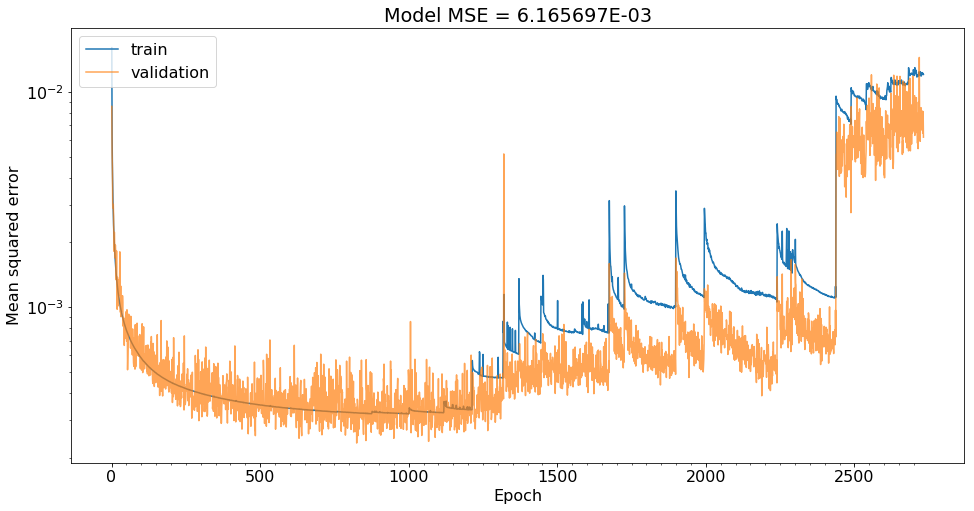

In [148]:
plot_model_history_fromDict(historyDict)

In [39]:
# save model
model.save(os.path.join(savedModels,  modelName + '.h5'))

# save weights
wts = model.get_weights().copy()

wtsFile = modelName + '_wts.pkl'
pickle.dump(wts, open(os.path.join(dataOutput, wtsFile), 'wb'))

# save history with same name as model
historyFile = modeltimestamp + '_history.pkl'
pickle.dump(historyDict, open(os.path.join(dataOutput, historyFile), 'wb'))

In [40]:
#  plot error rates on test data

In [41]:
# predict on test set
Ytest_pred = model.predict(Xtest_scaled)


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = Xtrain.columns)
YtestDF = pd.DataFrame(Ytest, columns = Ytrain.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Ytrain.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()


,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,Fx_pred,Fy_pred,tau_pred,x_dot_99_pred,y_dot_99_pred,phi_dot_99_pred,theta_dot_99_pred
0,-5342.432439,14670.842555,-57718.558932,-577.070011,-1317.410003,-76.817401,-84.515766,-8094.202637,12740.980469,-62151.730469,-569.828308,-1386.766479,-90.226501,-97.260246
1,-2515.747661,3418.036434,-64775.342625,-18.839022,1292.672193,17.808851,1.199298,-2166.466309,5914.931152,-73559.101562,-0.544303,1276.641724,24.255011,8.650805
2,-6497.950980,-17669.503572,-49237.798014,-1094.713883,-1469.532303,124.939700,115.462788,-3939.314697,-16204.042969,-58901.363281,-1071.320312,-1407.566162,125.001846,114.140678
3,24237.433019,-8489.629561,56490.932254,-187.441953,-427.573908,100.329900,100.827942,23393.248047,-5967.558105,47613.828125,-193.233765,-458.909576,93.720085,93.064659
4,1782.839206,5791.542006,26503.920442,625.069923,31.217768,-26.216617,-20.827598,2373.806885,3526.097656,22228.365234,706.043274,34.890289,-35.648159,-32.941639


In [42]:
print("Evaluate on test data")
results = model.evaluate(Xtest_scaled, Ytest, batch_size=128)
print("test loss, test mse:", results)

Evaluate on test data
5000000/5000000 [==============================] - 63s 13us/sample - loss: 569732153.6979 - mean_squared_error: 569736448.0000
test loss, test mse: [569732153.6978945, 569736450.0]


In [44]:
#df_c = df_c.iloc[:1000, :]

# df_c = df_c.replace([np.inf, -np.inf], np.nan)
# df_c = df_c.replace([np.inf, -np.inf], np.nan).dropna()

In [43]:
import matplotlib.ticker as mtick
import matplotlib
class MathTextSciFormatter(mtick.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            return(" ")
        return "${}$".format(s)

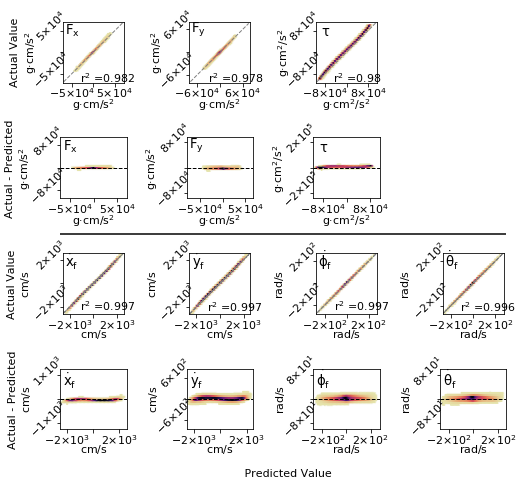

In [44]:
# make plots
from sklearn.metrics import r2_score
from matplotlib import ticker
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.default'] = 'regular'
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 11})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.transforms as mtrans


fig_col_names = [r'$F_x$', r'$F_y$', r'$\tau$', r'$\dot{x}_f$', r'$\dot{y}_f$', r'$\dot{\phi}_f$', r'$\dot{\theta}_f$']

plt.close("all")
fig, axs = plt.subplots(4,4, figsize=np.array([8, 7.5]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.9, wspace=.9)
# fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r'$g·cm/s^2$', "$g·cm/s^2$", "$g·cm^2/s^2$", "$cm/s$", "$cm/s$", "$rad/s$", "$rad/s$"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
# make really low-value hexbins white
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii in np.arange(0, 3):
    axs[ii].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[ii].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].set_yticklabels(axs[ii].get_yticklabels(), 
                            rotation = 45, ha="center",
                            va = "bottom", rotation_mode="anchor")
    axs[ii].yaxis.set_label_coords(-0.4,0.5)
    axs[ii].set_xlabel(ylabs[ii] + "\n")
    axs[ii].xaxis.set_label_coords(0.5,-0.2)
    axs[ii].tick_params(axis="x",direction="out", pad=-0)
    

    if(ii == 0):
        axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
    else:
        axs[ii].set_ylabel(ylabs[ii])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[ii].set_title(fig_col_names[ii], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[ii].title
    ttl.set_position([.15, 0.62])
    
    # draw identity lines
    lims = [
        np.min([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # min of both axes
        np.max([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # max of both axes
        ]
    axs[ii].plot(lims, lims,  
                 'grey', linewidth = 1, linestyle  = "--")
#     axs[ii].plot(df_c.loc[:,YtestDF.columns[ii]], 
#                  df_c.loc[:,YtestDF.columns[ii]], 
#                  'grey', linewidth = 1, linestyle  = "--")
    axs[ii].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].set_aspect('equal', 'box')

    # annotate with R^2
    axs[ii].text(np.max(lims)*-0.4, 
                 np.min(lims)*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[ii].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])
    axs[ii].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(4, 7)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.2)
    
    if jj == 3:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                      Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 0):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])
        
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.62])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
#####
#### Part 2
#####

#fig.subplots_adjust(hspace = 0.9, wspace=.9)

# Plot y = actual, x = predicted
for plotnum, dataColNum in zip(np.arange(8,12), np.arange(3, 7)):
    axs[plotnum].hexbin(y = df_c.loc[:,YtestDF.columns[dataColNum]],
                   x = df_c.loc[:,YpredDF.columns[dataColNum]], 
                   gridsize = 50, cmap = cmap)
    axs[plotnum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].set_yticklabels(axs[plotnum].get_yticklabels(),
                                 rotation = 45, ha="center",
                                 va = "bottom", rotation_mode="anchor")
    axs[plotnum].yaxis.set_label_coords(-0.5,0.5)
    axs[plotnum].set_xlabel(ylabs[dataColNum] + "\n")
    axs[plotnum].xaxis.set_label_coords(0.5,-0.2)

    if(plotnum == 8):
        axs[plotnum].set_ylabel("Actual Value\n" + ylabs[dataColNum])
    else:
        axs[plotnum].set_ylabel(ylabs[dataColNum])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[plotnum].set_title(fig_col_names[dataColNum], 
                           fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotnum].title
    ttl.set_position([.15, 0.60])
    axs[plotnum].plot(df_c.loc[:,YtestDF.columns[dataColNum]], 
                 df_c.loc[:,YtestDF.columns[dataColNum]], 
                 'grey', linewidth = 1, linestyle  = "--")
    axs[plotnum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].set_aspect('equal', 'box')

    # annotate with R^2
    axs[plotnum].text(np.max(df_c.loc[:,YtestDF.columns[dataColNum]])*-0.4, 
                 np.min(df_c.loc[:,YtestDF.columns[dataColNum]])*0.85, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[dataColNum]],  
                                        df_c.loc[:,YpredDF.columns[dataColNum]])), 3)))
    axs[plotnum].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    axs[plotnum].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    
    axs[plotnum].tick_params(axis="x",direction="out", pad=-0)

# residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
# refref Here
for jj, plotNum in zip(np.arange(3, 7), np.arange(12, 16)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.2)
    
    if jj == 4:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                                       Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 3):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.55])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
    
axs[3].axis('off')
axs[7].axis('off')

# add black horizontal line
ax3 = plt.figure(1).add_subplot(111)
ax3.plot([-1,1],[0.48,0.48], '-', color = "black" )
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.axis("off")

#plt.tight_layout()
#fig.savefig(os.path.join(figDir, "PredVActual" + modelName + ".pdf"),)
plt.show()
# plt.close()

In [45]:
## Pruning
modelName

'Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_07_23__09_04_49'

In [57]:
# load model
from tensorflow.keras.models import load_model

K.clear_session()

modelName =  "Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_07_23__09_04_49"
modeltimestamp = "2020_07_23__09_04_49"
model = load_model(os.path.join(savedModels,  modelName + ".h5"))

# load weights
wtsFile = modelName + '_wts.pkl'
wts = pickle.load(open(os.path.join(dataOutput, wtsFile), 'rb'))

# load history with same name as model
historyFile = modeltimestamp + '_history.pkl'
historyDict = pickle.load(open(os.path.join(dataOutput, historyFile), 'rb'))


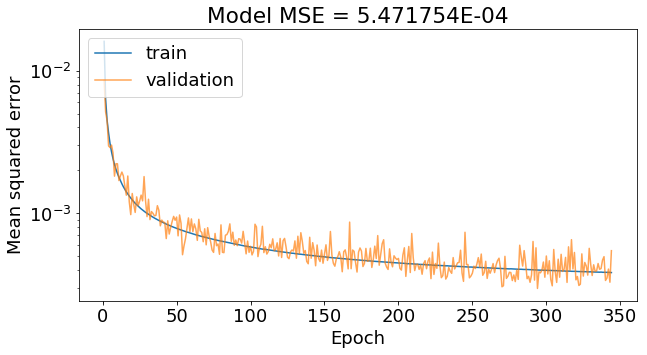

In [58]:
plt.rcParams.update({'font.size': 18})
plot_model_history_fromDict(historyDict)

In [59]:
# train with pruning
numCuts = 1

wts = model.get_weights()
wtLengths = []
for ii in range(len(wts)):
    wtLengths.append(np.prod(wts[ii].shape))

In [60]:
# make new folder to save each prune
modelSubdir = os.path.join(savedModels, modeltimestamp + "_checkpoints")
if not os.path.exists(modelSubdir):
    os.mkdir(modelSubdir)

In [61]:
# train until I have very good results
# then prune, and retrain until results are close
# change pruning rate as data get closer to 100% removed
def prune_percent_updater(x):
    logit = np.exp(x*8) / (np.exp(x*8) + 1)
    return((logit - 0.5)*2*50)

# cuts a smaller portion as the percent gets closer to 100%
cutPercent = prune_percent_updater(np.linspace(0, 1, 26))

print(cutPercent*2)

[ 0.         15.86485043 30.95069212 44.62436102 56.48995528 66.40367703
 74.42768674 80.75689166 85.64849155 89.36977272 92.16685544 94.25030081
 95.7917306  96.92645889 97.75871874 98.36748577 98.81189556 99.1358533
 99.37175734 99.54340943 99.66823978 99.75898315 99.82492807 99.87284121
 99.90764768 99.93292997]


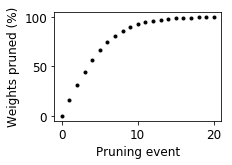

In [62]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=[3,2])
plt.plot((cutPercent*2)[0:21], ".", color = "black")
plt.xlabel("Pruning event")
plt.ylabel("Weights pruned (%)")
plt.savefig(os.path.join(figDir, "pruningPercentages.pdf"), bbox_inches='tight')

In [63]:
(cutPercent*2)[0:21]

array([ 0.        , 15.86485043, 30.95069212, 44.62436102, 56.48995528,
       66.40367703, 74.42768674, 80.75689166, 85.64849155, 89.36977272,
       92.16685544, 94.25030081, 95.7917306 , 96.92645889, 97.75871874,
       98.36748577, 98.81189556, 99.1358533 , 99.37175734, 99.54340943,
       99.66823978])

In [64]:
cutPercent

array([ 0.        ,  7.93242521, 15.47534606, 22.31218051, 28.24497764,
       33.20183851, 37.21384337, 40.37844583, 42.82424577, 44.68488636,
       46.08342772, 47.12515041, 47.8958653 , 48.46322944, 48.87935937,
       49.18374288, 49.40594778, 49.56792665, 49.68587867, 49.77170471,
       49.83411989, 49.87949158, 49.91246404, 49.9364206 , 49.95382384,
       49.96646499])

In [65]:
overallEpochCounter = len(historyDict['mean_squared_error'])
print(overallEpochCounter)

while True:   
   
    for numEpocs in range(100):
        
        MSE_tmp = []

        history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                            verbose = 2, batch_size=2**12, epochs = 1)
        
        overallEpochCounter += 1
        
        # save history
        historyDict["mean_squared_error"].append(history.history["mean_squared_error"][0])
        historyDict["val_mean_squared_error"].append(history.history["val_mean_squared_error"][0])
        
        # local MSE
        MSE_tmp.append(history.history["mean_squared_error"][0])

        # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
        # get nonzero weights
        wts = model.get_weights().copy()

        # set weights close to 0 to 0 (but ignore biases)
        for ii in np.arange(0, len(wts), 1):
            qants = np.percentile(np.reshape(wts[ii], -1), 
                                  q = (50 - cutPercent[numCuts], 
                                       50 + cutPercent[numCuts]), )
            wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

        # print nonzero weights
        # calculate number of nonzero weights
        nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
        print(nzwts, "of", np.sum(wtLengths), "weights retained")

        # set new weights and calculate new loss
        model.set_weights(wts)
        
        # check the change in mean squared error, and if it's not changing much, then cut out more data
        # calculate slope of loss, based on previous 5 data points
        if numEpocs > 5:
            inputData = historyDict["mean_squared_error"][-5:]

            m = np.shape(inputData)
            X = np.matrix([np.ones(m), np.arange(0, len(inputData))]).T
            y = np.matrix(np.log(inputData)).T

            # Solve for projection matrix
            intercept, slope = np.array(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)).reshape(-1,)
            print("change in log loss:", slope)
    
            # break if slope has stopped changing or if the overall min has been surpassed
            # in the first training, it will automatically prune after 5 epochs, because the min will be passed
            if (np.abs(slope) < 0.0001) or (history.history["mean_squared_error"][0] < np.min(historyDict["mean_squared_error"][:-1])): 
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                
                # save model
                model.save(os.path.join(savedModels,  modelSubdir, modelName + str(overallEpochCounter) + '_Pruned.h5'))
                
                
                # save weights
                wts = model.get_weights().copy()

                wtsFile = str(overallEpochCounter) + "_" + modelName + '_wts.pkl'
                pickle.dump(wts, open(os.path.join(savedModels, modelSubdir, wtsFile), 'wb'))

                # save history with same name as model
                historyFile = modeltimestamp + '_history.pkl'
                pickle.dump(historyDict, open(os.path.join(savedModels,modelSubdir, historyFile), 'wb'))
                
                numCuts += 1                
                break

    if numCuts >= len(cutPercent):
        break

        
        #cutPercent += 0.2
#winsound.PlaySound("*", winsound.SND_ALIAS)

344
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.8438e-04 - mean_squared_error: 3.8438e-04 - val_loss: 3.6338e-04 - val_mean_squared_error: 3.6338e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.8400e-04 - mean_squared_error: 3.8400e-04 - val_loss: 3.8809e-04 - val_mean_squared_error: 3.8809e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.8341e-04 - mean_squared_error: 3.8341e-04 - val_loss: 5.2656e-04 - val_mean_squared_error: 5.2656e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.8337e-04 - mean_squared_error: 3.8337e-04 - val_loss: 5.4834e-04 - val_mean_squared_error: 5.4834e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.8312e-04 - mean_square

111459 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.7812e-04 - mean_squared_error: 3.7812e-04 - val_loss: 3.4184e-04 - val_mean_squared_error: 3.4184e-04
111458 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.7734e-04 - mean_squared_error: 3.7734e-04 - val_loss: 3.5303e-04 - val_mean_squared_error: 3.5303e-04
111458 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.7658e-04 - mean_squared_error: 3.7658e-04 - val_loss: 3.9881e-04 - val_mean_squared_error: 3.9881e-04
111458 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.7669e-04 - mean_squared_error: 3.7669e-04 - val_loss: 3.8133e-04 - val_mean_squared_error: 3.8133e-04
111458 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - 

8000000/8000000 - 20s - loss: 3.7794e-04 - mean_squared_error: 3.7794e-04 - val_loss: 3.5223e-04 - val_mean_squared_error: 3.5223e-04
63844 of 331735 weights retained
change in log loss: -0.0008415222167966961
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.7792e-04 - mean_squared_error: 3.7792e-04 - val_loss: 3.3632e-04 - val_mean_squared_error: 3.3632e-04
63844 of 331735 weights retained
change in log loss: -0.0007982254028318522
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.7758e-04 - mean_squared_error: 3.7758e-04 - val_loss: 3.6537e-04 - val_mean_squared_error: 3.6537e-04
63844 of 331735 weights retained
change in log loss: -0.0007592678070067902
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.7766e-04 - mean_squared_error: 3.7766e-04 - val_loss: 3.4343e-04 - val_mean_squared_error: 3.4343e-04
63844 of 331735 weights retained
change in log loss: -0.000547170639038173

8000000/8000000 - 20s - loss: 3.8012e-04 - mean_squared_error: 3.8012e-04 - val_loss: 4.3030e-04 - val_mean_squared_error: 4.3030e-04
47618 of 331735 weights retained
change in log loss: -0.0011837959289550323
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.8022e-04 - mean_squared_error: 3.8022e-04 - val_loss: 4.1134e-04 - val_mean_squared_error: 4.1134e-04
47618 of 331735 weights retained
change in log loss: -0.0010261535644530348
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.7936e-04 - mean_squared_error: 3.7936e-04 - val_loss: 4.5552e-04 - val_mean_squared_error: 4.5552e-04
47618 of 331735 weights retained
change in log loss: -0.0009440422058104566
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.7903e-04 - mean_squared_error: 3.7903e-04 - val_loss: 4.4924e-04 - val_mean_squared_error: 4.4924e-04
47618 of 331735 weights retained
change in log loss: -0.000981569290160998

8000000/8000000 - 20s - loss: 3.9150e-04 - mean_squared_error: 3.9150e-04 - val_loss: 3.3584e-04 - val_mean_squared_error: 3.3584e-04
35276 of 331735 weights retained
change in log loss: -0.0009544849395751048
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.9048e-04 - mean_squared_error: 3.9048e-04 - val_loss: 4.1738e-04 - val_mean_squared_error: 4.1738e-04
35276 of 331735 weights retained
change in log loss: -0.0015036106109618235
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.9048e-04 - mean_squared_error: 3.9048e-04 - val_loss: 6.1417e-04 - val_mean_squared_error: 6.1417e-04
35276 of 331735 weights retained
change in log loss: -0.0015639781951906056
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 3.9009e-04 - mean_squared_error: 3.9009e-04 - val_loss: 4.1466e-04 - val_mean_squared_error: 4.1466e-04
35276 of 331735 weights retained
change in log loss: -0.001361751556396571

25994 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 5.5311e-04 - mean_squared_error: 5.5311e-04 - val_loss: 3.5207e-04 - val_mean_squared_error: 3.5207e-04
25994 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 5.4510e-04 - mean_squared_error: 5.4510e-04 - val_loss: 5.2459e-04 - val_mean_squared_error: 5.2459e-04
25994 of 331735 weights retained
change in log loss: -0.01756873130798326
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 5.4262e-04 - mean_squared_error: 5.4262e-04 - val_loss: 4.1036e-04 - val_mean_squared_error: 4.1036e-04
25994 of 331735 weights retained
change in log loss: -0.012289667129516419
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 5.3403e-04 - mean_squared_error: 5.3403e-04 - val_loss: 4.0465e-04 - val_mean_squared_error: 4.0465e-04
25994 of 331735 weights retained


8000000/8000000 - 20s - loss: 4.8651e-04 - mean_squared_error: 4.8651e-04 - val_loss: 4.1367e-04 - val_mean_squared_error: 4.1367e-04
25994 of 331735 weights retained
change in log loss: -0.003304910659790124
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 4.8809e-04 - mean_squared_error: 4.8809e-04 - val_loss: 5.4133e-04 - val_mean_squared_error: 5.4133e-04
25994 of 331735 weights retained
change in log loss: -0.0022358894348145824
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 4.8532e-04 - mean_squared_error: 4.8532e-04 - val_loss: 4.9469e-04 - val_mean_squared_error: 4.9469e-04
25994 of 331735 weights retained
change in log loss: -0.0027296066284179647
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 4.8550e-04 - mean_squared_error: 4.8550e-04 - val_loss: 2.9781e-04 - val_mean_squared_error: 2.9781e-04
25994 of 331735 weights retained
change in log loss: -0.0022662162780761677

25994 of 331735 weights retained
change in log loss: -4.510879516610063e-05
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 4.7206e-04 - mean_squared_error: 4.7206e-04 - val_loss: 5.0736e-04 - val_mean_squared_error: 5.0736e-04
19082 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 8.0902e-04 - mean_squared_error: 8.0902e-04 - val_loss: 4.1218e-04 - val_mean_squared_error: 4.1218e-04
19082 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 7.3511e-04 - mean_squared_error: 7.3511e-04 - val_loss: 

19082 of 331735 weights retained
change in log loss: -0.006030845642089837
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 6.0473e-04 - mean_squared_error: 6.0473e-04 - val_loss: 5.2498e-04 - val_mean_squared_error: 5.2498e-04
19082 of 331735 weights retained
change in log loss: -0.0063788890838624756
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 6.0104e-04 - mean_squared_error: 6.0104e-04 - val_loss: 4.4356e-04 - val_mean_squared_error: 4.4356e-04
19082 of 331735 weights retained
change in log loss: -0.006051349639892394
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 5.9753e-04 - mean_squared_error: 5.9753e-04 - val_loss: 5.6317e-04 - val_mean_squared_error: 5.6317e-04
19082 of 331735 weights retained
change in log loss: -0.005501747131347739
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 6.0113e-04 - mean_squared_error: 6.0113e-04 - val_l

8000000/8000000 - 20s - loss: 5.5283e-04 - mean_squared_error: 5.5283e-04 - val_loss: 4.7763e-04 - val_mean_squared_error: 4.7763e-04
19082 of 331735 weights retained
change in log loss: -0.001725196838378945
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 5.5223e-04 - mean_squared_error: 5.5223e-04 - val_loss: 6.0723e-04 - val_mean_squared_error: 6.0723e-04
19082 of 331735 weights retained
change in log loss: -0.0015652656555175727
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 5.5224e-04 - mean_squared_error: 5.5224e-04 - val_loss: 4.1685e-04 - val_mean_squared_error: 4.1685e-04
19082 of 331735 weights retained
change in log loss: -0.0012260437011717806
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 5.5092e-04 - mean_squared_error: 5.5092e-04 - val_loss: 4.1524e-04 - val_mean_squared_error: 4.1524e-04
19082 of 331735 weights retained
change in log loss: -0.0011550903320312444

8000000/8000000 - 20s - loss: 5.3340e-04 - mean_squared_error: 5.3340e-04 - val_loss: 4.6567e-04 - val_mean_squared_error: 4.6567e-04
13972 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 8.8871e-04 - mean_squared_error: 8.8871e-04 - val_loss: 5.3929e-04 - val_mean_squared_error: 5.3929e-04
13972 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 8.0495e-04 - mean_squared_error: 8.0495e-04 - val_loss: 5.4072e-04 - val_mean_squared_error: 5.4073e-04
13972 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 7.7549e-04 - mean_squared_error: 7.7549e-04 - val_loss: 5.6628e-04 - val_mean_squared_error: 5.6628e-04
13972 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 7.4662e-04 - mean_squared_error: 7.4662e-04 - val_loss: 6.3620e-04 - val_mean_squared_

13972 of 331735 weights retained
change in log loss: -0.0033294200897217613
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 6.4132e-04 - mean_squared_error: 6.4132e-04 - val_loss: 4.9171e-04 - val_mean_squared_error: 4.9171e-04
13972 of 331735 weights retained
change in log loss: -0.003090763092040964
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 6.3978e-04 - mean_squared_error: 6.3978e-04 - val_loss: 3.9149e-04 - val_mean_squared_error: 3.9149e-04
13972 of 331735 weights retained
change in log loss: -0.002792215347289943
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 6.3775e-04 - mean_squared_error: 6.3775e-04 - val_loss: 4.7381e-04 - val_mean_squared_error: 4.7381e-04
13972 of 331735 weights retained
change in log loss: -0.002312755584716701
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 6.3660e-04 - mean_squared_error: 6.3660e-04 - val_l

8000000/8000000 - 21s - loss: 6.0955e-04 - mean_squared_error: 6.0955e-04 - val_loss: 5.1697e-04 - val_mean_squared_error: 5.1697e-04
13972 of 331735 weights retained
change in log loss: -0.001573705673217678
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 21s - loss: 6.0894e-04 - mean_squared_error: 6.0894e-04 - val_loss: 4.9813e-04 - val_mean_squared_error: 4.9813e-04
13972 of 331735 weights retained
change in log loss: -0.0014537811279295033
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 21s - loss: 6.0840e-04 - mean_squared_error: 6.0840e-04 - val_loss: 4.2413e-04 - val_mean_squared_error: 4.2413e-04
13972 of 331735 weights retained
change in log loss: -0.001500034332275473
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 21s - loss: 6.0766e-04 - mean_squared_error: 6.0766e-04 - val_loss: 4.8104e-04 - val_mean_squared_error: 4.8104e-04
13972 of 331735 weights retained
change in log loss: -0.0015698432922362326


10208 of 331735 weights retained
change in log loss: -0.01942791938781755
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 9.0876e-04 - mean_squared_error: 9.0876e-04 - val_loss: 7.1013e-04 - val_mean_squared_error: 7.1013e-04
10208 of 331735 weights retained
change in log loss: -0.024136734008788872
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 8.9940e-04 - mean_squared_error: 8.9940e-04 - val_loss: 7.1816e-04 - val_mean_squared_error: 7.1816e-04
10208 of 331735 weights retained
change in log loss: -0.014701032638549794
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 8.8905e-04 - mean_squared_error: 8.8905e-04 - val_loss: 6.8302e-04 - val_mean_squared_error: 6.8302e-04
10208 of 331735 weights retained
change in log loss: -0.012803363800048729
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 8.8086e-04 - mean_squared_error: 8.8086e-04 - val_los

8000000/8000000 - 20s - loss: 7.6915e-04 - mean_squared_error: 7.6915e-04 - val_loss: 6.0012e-04 - val_mean_squared_error: 6.0012e-04
10208 of 331735 weights retained
change in log loss: -0.005008459091186514
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 7.6703e-04 - mean_squared_error: 7.6703e-04 - val_loss: 6.0837e-04 - val_mean_squared_error: 6.0837e-04
10208 of 331735 weights retained
change in log loss: -0.004465007781982591
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 7.6246e-04 - mean_squared_error: 7.6246e-04 - val_loss: 5.4144e-04 - val_mean_squared_error: 5.4144e-04
10208 of 331735 weights retained
change in log loss: -0.004130268096923997
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 7.6115e-04 - mean_squared_error: 7.6115e-04 - val_loss: 6.3516e-04 - val_mean_squared_error: 6.3516e-04
10208 of 331735 weights retained
change in log loss: -0.003852128982544114
Tr

10208 of 331735 weights retained
change in log loss: -0.002198410034179635
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 7.1668e-04 - mean_squared_error: 7.1668e-04 - val_loss: 5.6774e-04 - val_mean_squared_error: 5.6774e-04
10208 of 331735 weights retained
change in log loss: -0.0020058155059813924
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 7.1697e-04 - mean_squared_error: 7.1697e-04 - val_loss: 6.2356e-04 - val_mean_squared_error: 6.2356e-04
10208 of 331735 weights retained
change in log loss: -0.0010131359100342156
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 7.1553e-04 - mean_squared_error: 7.1553e-04 - val_loss: 5.0244e-04 - val_mean_squared_error: 5.0244e-04
10208 of 331735 weights retained
change in log loss: -0.0009912490844728255
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 7.1459e-04 - mean_squared_error: 7.1459e-04 - val

8000000/8000000 - 20s - loss: 9.4047e-04 - mean_squared_error: 9.4047e-04 - val_loss: 6.8870e-04 - val_mean_squared_error: 6.8870e-04
7448 of 331735 weights retained
change in log loss: -0.014337587356567549
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 9.2849e-04 - mean_squared_error: 9.2849e-04 - val_loss: 8.6129e-04 - val_mean_squared_error: 8.6129e-04
7448 of 331735 weights retained
change in log loss: -0.01358442306518558
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 9.1950e-04 - mean_squared_error: 9.1950e-04 - val_loss: 6.3405e-04 - val_mean_squared_error: 6.3405e-04
7448 of 331735 weights retained
change in log loss: -0.01267919540405259
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 9.0906e-04 - mean_squared_error: 9.0906e-04 - val_loss: 7.8033e-04 - val_mean_squared_error: 7.8033e-04
7448 of 331735 weights retained
change in log loss: -0.011801242828368997
Train on

7448 of 331735 weights retained
change in log loss: -0.003227853775024316
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 7.6853e-04 - mean_squared_error: 7.6853e-04 - val_loss: 6.4633e-04 - val_mean_squared_error: 6.4633e-04
7448 of 331735 weights retained
change in log loss: -0.0031929492950441138
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 7.6688e-04 - mean_squared_error: 7.6688e-04 - val_loss: 7.1631e-04 - val_mean_squared_error: 7.1631e-04
7448 of 331735 weights retained
change in log loss: -0.0027852535247803087
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 7.6566e-04 - mean_squared_error: 7.6566e-04 - val_loss: 6.4801e-04 - val_mean_squared_error: 6.4801e-04
7448 of 331735 weights retained
change in log loss: -0.0027291774749756657
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 7.6194e-04 - mean_squared_error: 7.6194e-04 - val_los

8000000/8000000 - 20s - loss: 7.2994e-04 - mean_squared_error: 7.2994e-04 - val_loss: 5.3785e-04 - val_mean_squared_error: 5.3785e-04
5430 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
5430 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
5430 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
5430 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
5430 of 331735 weights retained
Train on 8000000 s

8000000/8000000 - 20s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 8.3637e-04 - val_mean_squared_error: 8.3637e-04
5430 of 331735 weights retained
change in log loss: -0.005904483795166003
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 8.4380e-04 - val_mean_squared_error: 8.4380e-04
5430 of 331735 weights retained
change in log loss: -0.007333850860595867
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 7.7951e-04 - val_mean_squared_error: 7.7951e-04
5430 of 331735 weights retained
change in log loss: -0.008176469802856166
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 7.1537e-04 - val_mean_squared_error: 7.1537e-04
5430 of 331735 weights retained
change in log loss: -0.009431362152099507
Train on 8000000 samples, validate on 

8000000/8000000 - 20s - loss: 9.6793e-04 - mean_squared_error: 9.6793e-04 - val_loss: 5.3657e-04 - val_mean_squared_error: 5.3657e-04
5430 of 331735 weights retained
change in log loss: -0.003028202056884665
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 9.6989e-04 - mean_squared_error: 9.6989e-04 - val_loss: 5.7818e-04 - val_mean_squared_error: 5.7818e-04
5430 of 331735 weights retained
change in log loss: -0.0028878688812254854
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 9.6915e-04 - mean_squared_error: 9.6915e-04 - val_loss: 7.1035e-04 - val_mean_squared_error: 7.1035e-04
5430 of 331735 weights retained
change in log loss: -0.0031515598297119024
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 9.6581e-04 - mean_squared_error: 9.6581e-04 - val_loss: 5.9308e-04 - val_mean_squared_error: 5.9308e-04
5430 of 331735 weights retained
change in log loss: -0.0032865524291992515
Tra

5430 of 331735 weights retained
change in log loss: -0.0008775234222413776
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 9.0890e-04 - mean_squared_error: 9.0890e-04 - val_loss: 6.0751e-04 - val_mean_squared_error: 6.0751e-04
5430 of 331735 weights retained
change in log loss: 0.001134967803955178
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 9.0543e-04 - mean_squared_error: 9.0543e-04 - val_loss: 5.9074e-04 - val_mean_squared_error: 5.9074e-04
5430 of 331735 weights retained
change in log loss: 0.0011226654052735373
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 8.9941e-04 - mean_squared_error: 8.9941e-04 - val_loss: 4.9858e-04 - val_mean_squared_error: 4.9858e-04
5430 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 8.9614e-04 - mean_squared_error: 8.9614e-04 - val_loss: 5.7663e-04 - val_mean_squared_error: 5.766

8000000/8000000 - 20s - loss: 8.8574e-04 - mean_squared_error: 8.8574e-04 - val_loss: 5.4147e-04 - val_mean_squared_error: 5.4147e-04
5430 of 331735 weights retained
change in log loss: 0.0012075901031494694
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 9.0467e-04 - mean_squared_error: 9.0467e-04 - val_loss: 5.0584e-04 - val_mean_squared_error: 5.0584e-04
5430 of 331735 weights retained
change in log loss: 0.0028729915618896595
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 8.8589e-04 - mean_squared_error: 8.8589e-04 - val_loss: 4.6961e-04 - val_mean_squared_error: 4.6961e-04
5430 of 331735 weights retained
change in log loss: -0.0030334949493408983
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 8.9899e-04 - mean_squared_error: 8.9899e-04 - val_loss: 4.8752e-04 - val_mean_squared_error: 4.8752e-04
5430 of 331735 weights retained
change in log loss: -0.0003139972686768357
Trai

5430 of 331735 weights retained
change in log loss: -0.00442495346069326
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 8.4873e-04 - mean_squared_error: 8.4873e-04 - val_loss: 5.2580e-04 - val_mean_squared_error: 5.2580e-04
5430 of 331735 weights retained
change in log loss: -0.003556060791015437
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 8.4659e-04 - mean_squared_error: 8.4659e-04 - val_loss: 4.9204e-04 - val_mean_squared_error: 4.9204e-04
5430 of 331735 weights retained
change in log loss: -0.003342390060424972
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 8.4743e-04 - mean_squared_error: 8.4743e-04 - val_loss: 5.0220e-04 - val_mean_squared_error: 5.0220e-04
5430 of 331735 weights retained
change in log loss: -0.0023628234863282923
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 8.4614e-04 - mean_squared_error: 8.4614e-04 - val_loss: 

8000000/8000000 - 20s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
3954 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 8.3186e-04 - val_mean_squared_error: 8.3186e-04
3954 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 8.1934e-04 - val_mean_squared_error: 8.1934e-04
3954 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
3954 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 8.8262e-04 - val_mean_squared_error: 8.8262e-04
3954 of 331735 weights retained
change in 

8000000/8000000 - 20s - loss: 9.9965e-04 - mean_squared_error: 9.9965e-04 - val_loss: 6.1469e-04 - val_mean_squared_error: 6.1469e-04
3954 of 331735 weights retained
change in log loss: -0.003640413284301568
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 9.9597e-04 - mean_squared_error: 9.9597e-04 - val_loss: 5.9305e-04 - val_mean_squared_error: 5.9305e-04
3954 of 331735 weights retained
change in log loss: -0.0033092498779295865
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 9.9384e-04 - mean_squared_error: 9.9384e-04 - val_loss: 6.6215e-04 - val_mean_squared_error: 6.6215e-04
3954 of 331735 weights retained
change in log loss: -0.0031673431396485588
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 9.9187e-04 - mean_squared_error: 9.9187e-04 - val_loss: 5.8510e-04 - val_mean_squared_error: 5.8510e-04
3954 of 331735 weights retained
change in log loss: -0.0030835628509522698
Tra

8000000/8000000 - 20s - loss: 9.3728e-04 - mean_squared_error: 9.3728e-04 - val_loss: 5.1889e-04 - val_mean_squared_error: 5.1889e-04
2878 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
2878 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
2878 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
2878 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
2878 of 331735 weights retained
Train on 8000000 s

2878 of 331735 weights retained
change in log loss: -0.016691255569457903
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 9.7438e-04 - val_mean_squared_error: 9.7438e-04
2878 of 331735 weights retained
change in log loss: -0.009351921081542952
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 7.3203e-04 - val_mean_squared_error: 7.3203e-04
2878 of 331735 weights retained
change in log loss: -0.004599237442016496
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 8.0374e-04 - val_mean_squared_error: 8.0374e-04
2878 of 331735 weights retained
change in log loss: -0.005864381790161205
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 9.5903e-04 - val_mean_squared_er

8000000/8000000 - 20s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 7.0662e-04 - val_mean_squared_error: 7.0662e-04
2878 of 331735 weights retained
change in log loss: -0.005396747589111314
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 7.4492e-04 - val_mean_squared_error: 7.4492e-04
2878 of 331735 weights retained
change in log loss: -0.003194427490234449
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 8.6335e-04 - val_mean_squared_error: 8.6335e-04
2878 of 331735 weights retained
change in log loss: -0.004252767562866107
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 7.2407e-04 - val_mean_squared_error: 7.2407e-04
2878 of 331735 weights retained
change in log loss: 0.0002608776092528555
Train on 8000000 samples, validate on 

2878 of 331735 weights retained
change in log loss: -0.0052951812744141385
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 6.9221e-04 - val_mean_squared_error: 6.9221e-04
2878 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.3186e-04 - val_mean_squared_error: 5.3186e-04
2878 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.5388e-04 - val_mean_squared_error: 5.5388e-04
2878 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 6.0212e-04 - val_mean_squared_error: 6.0212e-04
2878 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s -

2098 of 331735 weights retained
change in log loss: -0.005523252487182779
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.0058e-04 - val_mean_squared_error: 7.0058e-04
2098 of 331735 weights retained
change in log loss: -0.020801925659179762
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.7714e-04 - val_mean_squared_error: 7.7714e-04
2098 of 331735 weights retained
change in log loss: -0.02524991035461424
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.1361e-04 - val_mean_squared_error: 7.1361e-04
2098 of 331735 weights retained
change in log loss: -0.025374794006347373
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 6.8697e-04 - val_mean_squared_err

1526 of 331735 weights retained
change in log loss: -0.005806732177734314
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 7.8920e-04 - val_mean_squared_error: 7.8920e-04
1526 of 331735 weights retained
change in log loss: -0.0013700008392335586
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 9.7609e-04 - val_mean_squared_error: 9.7609e-04
1526 of 331735 weights retained
change in log loss: 0.0025850772857665743
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 8.2774e-04 - val_mean_squared_error: 8.2774e-04
1526 of 331735 weights retained
change in log loss: -0.000548267364501936
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 7.3052e-04 - val_mean_squared_e

8000000/8000000 - 20s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 6.7894e-04 - val_mean_squared_error: 6.7894e-04
1526 of 331735 weights retained
change in log loss: 0.0011045455932619122
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.6710e-04 - val_mean_squared_error: 7.6710e-04
1526 of 331735 weights retained
change in log loss: -0.001037645339965627
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.7712e-04 - val_mean_squared_error: 7.7712e-04
1526 of 331735 weights retained
change in log loss: 1.3446807861166184e-05
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
************************************************ PRUNING ******

8000000/8000000 - 20s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
810 of 331735 weights retained
change in log loss: -0.013317060470581118
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
810 of 331735 weights retained
change in log loss: -0.013094329833984482
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
810 of 331735 weights retained
change in log loss: 0.019068384170532256
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
810 of 331735 weights retained
change in log loss: -0.006867408752441336
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s

596 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
596 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
596 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
596 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
596 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0099 - val_mean_squared

8000000/8000000 - 20s - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
596 of 331735 weights retained
change in log loss: 0.0055002212524414935
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
596 of 331735 weights retained
change in log loss: 0.0005367755889892118
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
596 of 331735 weights retained
change in log loss: 0.0020299434661864776
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
596 of 331735 weights retained
change in log loss: 0.015139961242675781
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s

8000000/8000000 - 20s - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
436 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
435 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
436 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
436 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
436 of 331735 weights retained
Train on 8000000 samples, validate on 2

8000000/8000000 - 21s - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
436 of 331735 weights retained
change in log loss: -0.014001607894897483
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 21s - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
436 of 331735 weights retained
change in log loss: -0.008673810958862306
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 22s - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
436 of 331735 weights retained
change in log loss: 0.009916448593139648
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 21s - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
436 of 331735 weights retained
change in log loss: 0.005534172058105468
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 21s 

436 of 331735 weights retained
change in log loss: 0.041120624542236466
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
436 of 331735 weights retained
change in log loss: -6.620883941654742e-05
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
318 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.023

238 of 331735 weights retained
change in log loss: -0.001139998435974071
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
238 of 331735 weights retained
change in log loss: -0.001769256591796825
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
238 of 331735 weights retained
change in log loss: -0.002493715286254899
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
238 of 331735 weights retained
change in log loss: -0.001618838310241649
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 20s - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
238 of 331735 weight

In [71]:
historyFile = modeltimestamp + '_CallinPruned_history.pkl'
pickle.dump(historyDict, open(os.path.join(savedModels,modelSubdir, historyFile), 'wb'))

In [66]:
# get cut points
savedChecks = [f for f in os.listdir(os.path.join(savedModels, modelSubdir)) if f.endswith('wts.pkl')]
vlines = [int(savedChecks[ii][0:4].replace("_", "")) for ii in range(len(savedChecks)) if savedChecks[ii][0].isdigit()]

In [67]:
len(vlines)

25

In [68]:
vlines.sort()
vlines.insert(0, 476) # this is the first cut  -- not saved
vlines

[476,
 352,
 359,
 366,
 373,
 381,
 393,
 417,
 451,
 493,
 561,
 653,
 735,
 828,
 905,
 1095,
 1160,
 1279,
 1307,
 1360,
 1378,
 1421,
 1490,
 1560,
 1575,
 1596]

In [69]:
list(zip(vlines, [np.round(cutPercent[jj+1]*2, 2) for jj in  range(len(vlines))]))

IndexError: index 26 is out of bounds for axis 0 with size 26

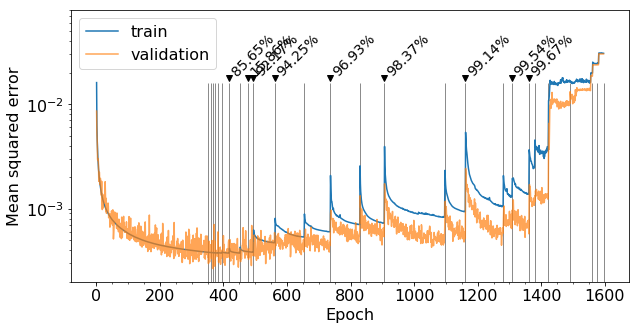

In [70]:
plt.rcParams.update({'font.size': 16})
plot_model_history_fromDict(historyDict)


for vline in vlines:
    plt.vlines(vline+1, ymin = 0, ymax = historyDict["mean_squared_error"][0], alpha = 0.5, linewidth = 0.9)

plt.ylim(10**-3.7, 10**-1.1)
plt.title("")

for jj in [0,7,9, 10,12, 14,16,18, 19]:
    s = str(np.round(cutPercent[jj+1]*2, 2)) + "%"
    plt.plot(vlines[jj], 10**-1.75, "v", color = "black")
    plt.text(vlines[jj], 10**-1.75, s,{'ha': 'left', 'va': 'bottom'}, fontsize=14, rotation=45)
plt.savefig(os.path.join(figDir, "ModelPruning_" + modelName + ".pdf"), bbox_inches='tight')
plt.show()

In [61]:
## Reload model with 80% of connections pruned and evaluate error

In [62]:
K.clear_session()


modelName =  "Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_01_27__01_30_06572_Pruned"
modeltimestamp = "2020_01_27__01_30_06"
model = load_model(os.path.join(savedModels, modelSubdir,  modelName + ".h5"))

# Pruning with Tensorflow Model Optimization Toolkit

## Prune fixed amount of initial model
(rather than the sequential pruning)

In [141]:
wts = model.get_weights()

In [92]:
from tensorflow.keras.models import load_model

import tensorflow_model_optimization as tfmot

import tempfile
import os

In [93]:
modelName

'Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_07_23__09_04_49'

In [94]:
K.clear_session()

modelName = 'Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_07_23__09_04_49'
modeltimestamp = "2020_07_23__09_04_49"
model = load_model(os.path.join(savedModels,  modelName + ".h5"))

# load history with same name as model
historyFile = modeltimestamp + '_history.pkl'
historyDict = pickle.load(open(os.path.join(dataOutput, historyFile), 'rb'))

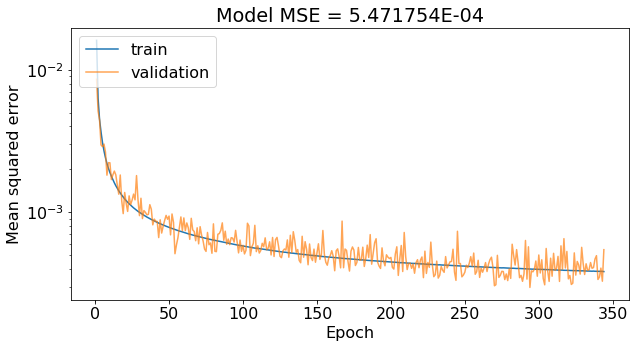

In [95]:
plot_model_history_fromDict(historyDict)

In [96]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
ConstantSparsity = tfmot.sparsity.keras.ConstantSparsity

### Define pruning parameters 

In [97]:
def define_pruning_params(percent_pruned):
    '''
    '''
    
    pruning_params = {
        'pruning_schedule': ConstantSparsity(percent_pruned,0),
        'block_size': (1,1),
        'block_pooling_type': 'AVG'
    }
    
    return(pruning_params)

### Create model for pruning

In [98]:
def create_pruned_model(model, 
                        pruning_params,
                        optimizer = 'rmsprop'):

    '''
    '''
    
    pruned_model = prune_low_magnitude(model, **pruning_params)
    
    pruned_model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])
    
    return(pruned_model)

In [99]:
logdir = tempfile.mkdtemp()

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir = logdir),
    earlystop,

]

In [100]:
pruning_params = define_pruning_params(0.90)
pruned_model = create_pruned_model(model, pruning_params)

In [101]:
pruned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 400)               8402      
_________________________________________________________________
prune_low_magnitude_dense_1  (None, 400)               320402    
_________________________________________________________________
prune_low_magnitude_dense_2  (None, 400)               320402    
_________________________________________________________________
prune_low_magnitude_dense_3  (None, 16)                12818     
_________________________________________________________________
prune_low_magnitude_dense_4  (None, 7)                 233       
Total params: 662,257
Trainable params: 331,735
Non-trainable params: 330,522
_________________________________________________

In [109]:
wts = pruned_model.get_weights()
wts = np.array(wts)
wts = wts.reshape(5,5)
len(wts)

/home/olivia/anaconda3/envs/deepLearn_V4/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


5

In [105]:
pruned_history = pruned_model.fit(Xtrain_scaled, Ytrain_scaled, 
                                  validation_data=(Xval_scaled, Yval_scaled),
                                  callbacks = callbacks,
                                  verbose = 2, batch_size=2**12, epochs = 500)

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/500
8000000/8000000 - 28s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 2/500
8000000/8000000 - 28s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 3/500
8000000/8000000 - 28s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 4/500
8000000/8000000 - 28s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 5/500
8000000/8000000 - 28s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 6/500
8000000/8000000 - 28s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 7/500
8000000/8000000 - 28s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 8/500
8000000/8000000 - 28s - 

In [106]:
historyDict["mean_squared_error"].extend(pruned_history.history['mean_squared_error'])
historyDict["val_mean_squared_error"].extend(pruned_history.history['val_mean_squared_error'])

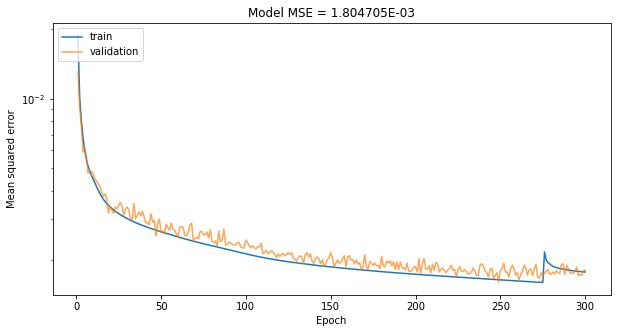

In [107]:
plot_model_history_fromDict(historyDict)

In [135]:
wts = pruned_model.get_weights()
wts3 = wts[-3].reshape(1,16*7)[0]
tot = 0
for i in range(len(wts3)):
    if wts3[i] == 1:
        tot += 1
        
print(tot/(16*17))
    

0.04044117647058824


In [136]:
wts[-2]

0.294134

In [111]:
print("Evaluate on test data")
results = pruned_model.evaluate(Xtest_scaled, Ytest, batch_size=128)
print("test loss, test mse:", results)

Evaluate on test data
5000000/5000000 [==============================] - 87s 17us/sample - loss: 569733111.1408 - mean_squared_error: 569737344.0000
test loss, test acc: [569733111.1407616, 569737340.0]


In [112]:
print("Evaluate on test data")
results = model.evaluate(Xtest_scaled, Ytest, batch_size=128)
print("test loss, test mse:", results)

Evaluate on test data
5000000/5000000 [==============================] - 86s 17us/sample - loss: 569733111.1408 - mean_squared_error: 569737344.0000
test loss, test mse: [569733111.1407616, 569737340.0]


## Sequential pruning

In [160]:
from tensorflow.keras.models import load_model

import tensorflow_model_optimization as tfmot

import tempfile
import os

In [161]:
modelName

'Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_07_23__09_04_49'

In [162]:
K.clear_session()

modelName = 'Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_07_23__09_04_49'
modeltimestamp = "2020_07_23__09_04_49"
model = load_model(os.path.join(savedModels,  modelName + ".h5"))

# load history with same name as model
historyFile = modeltimestamp + '_history.pkl'
historyDict = pickle.load(open(os.path.join(dataOutput, historyFile), 'rb'))

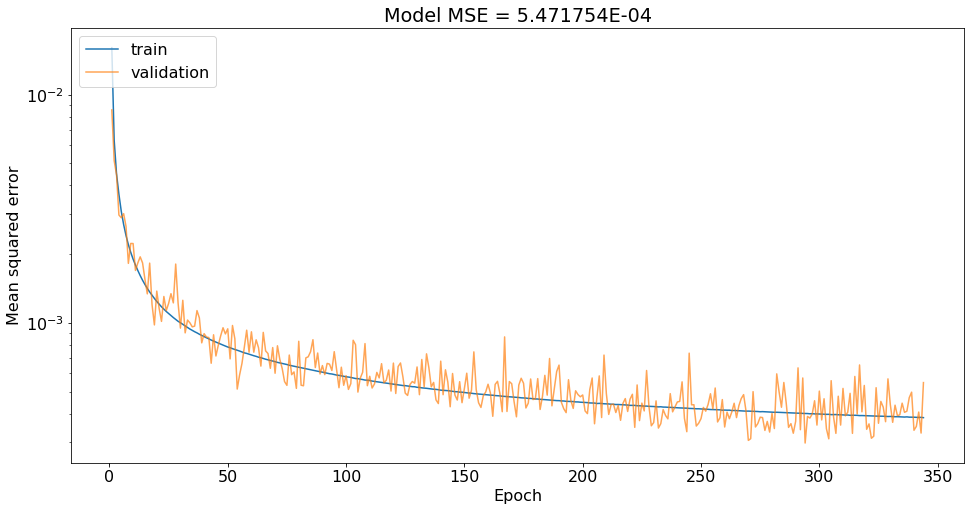

In [163]:
plot_model_history_fromDict(historyDict)

In [164]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
ConstantSparsity = tfmot.sparsity.keras.ConstantSparsity

- iterate through pruning percentages 
- call define pruning parameters on each iteration
- call pruning model function on each iteration
- add history to dictionary on each iteration 

Idea: create function that takes in list of pruning percentages (generated above by Callin's old code). This function will iterate through that list and on each iteration call define_pruning_params and create_pruned_model. Each time, the pruned model should probably be saved, for future analysis of structure after each prune. 

In [165]:
# train until I have very good results
# then prune, and retrain until results are close
# change pruning rate as data get closer to 100% removed
def prune_percent_updater(x):
    '''
    Prune percent updater by C.S.
    # train until I have very good results
    # then prune, and retrain until results are close
    # change pruning rate as data get closer to 100% removed
    '''
    logit = np.exp(x*8) / (np.exp(x*8) + 1)
    return(((logit - 0.5)*2*50)*2*0.01)

In [166]:
cutPercent = prune_percent_updater(np.linspace(0, 1, 26))
cutPercent = np.delete(cutPercent, 0)

print(cutPercent)

[0.1586485  0.30950692 0.44624361 0.56489955 0.66403677 0.74427687
 0.80756892 0.85648492 0.89369773 0.92166855 0.94250301 0.95791731
 0.96926459 0.97758719 0.98367486 0.98811896 0.99135853 0.99371757
 0.99543409 0.9966824  0.99758983 0.99824928 0.99872841 0.99907648
 0.9993293 ]


In [51]:
# make new folder to save each prune
modelSubdir = os.path.join(savedModels, modeltimestamp + "_checkpoints")
if not os.path.exists(modelSubdir):
    os.mkdir(modelSubdir)

In [167]:
def sequential_Pruning(model, cutPercent):
    '''
    '''
    
    for i in cutPercent:
        pruning_params = define_pruning_params(i)
        pruned_model = create_pruned_model(model, pruning_params)
        
        pruned_history = pruned_model.fit(Xtrain_scaled, Ytrain_scaled, 
                                  validation_data=(Xval_scaled, Yval_scaled),
                                  callbacks = callbacks,
                                  verbose = 2, batch_size=2**12, epochs = 500)
        
        historyDict["mean_squared_error"].extend(pruned_history.history['mean_squared_error'])
        historyDict["val_mean_squared_error"].extend(pruned_history.history['val_mean_squared_error'])
        
        cut_epochs.append(len(pruned_history.history['mean_squared_error']) + cut_epochs[-1])

        
        print("************************************************ PRUNING ********************************************************")
        print("************************************************ PRUNING ********************************************************")
        print("************************************************ PRUNING ********************************************************")
        
        p_wts = pruned_model.get_weights()
        
        p_wts = np.array(p_wts)
        p_wts = p_wts.reshape(5,5)
        
        pruned_weights = []
        
        for i in range(len(p_wts)):
            pruned_weights.append(p_wts[i][0])
            pruned_weights.append(p_wts[i][1])
        #for i in range(0,len(p_wts),4):
            #pruned_weights.append(p_wts[i])
            
        model.set_weights(pruned_weights)
        
        # save model
        model.save(os.path.join(savedModels,  modelSubdir, modelName + '_' + str(i) + 'earlystop_0.0001_Pruned.h5'))
        
    return cut_epochs

In [168]:
#Keep track of which epochs a prune occurs
cut_epochs = [len(historyDict["mean_squared_error"])]

sequential_Pruning(model, cutPercent)

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/500
8000000/8000000 - 29s - loss: 3.8655e-04 - mean_squared_error: 3.8655e-04 - val_loss: 3.9513e-04 - val_mean_squared_error: 3.9513e-04
Epoch 2/500
8000000/8000000 - 29s - loss: 3.8374e-04 - mean_squared_error: 3.8374e-04 - val_loss: 4.1344e-04 - val_mean_squared_error: 4.1344e-04
Epoch 3/500
8000000/8000000 - 30s - loss: 3.8337e-04 - mean_squared_error: 3.8337e-04 - val_loss: 3.2849e-04 - val_mean_squared_error: 3.2849e-04
Epoch 4/500
8000000/8000000 - 29s - loss: 3.8276e-04 - mean_squared_error: 3.8276e-04 - val_loss: 4.4687e-04 - val_mean_squared_error: 4.4687e-04
Epoch 5/500
8000000/8000000 - 29s - loss: 3.8308e-04 - mean_squared_error: 3.8308e-04 - val_loss: 5.6143e-04 - val_mean_squared_error: 5.6143e-04
Epoch 6/500
8000000/8000000 - 29s - loss: 3.8230e-04 - mean_squared_error: 3.8230e-04 - val_loss: 4.0646e-04 - val_mean_squared_error: 4.0646e-04
Epoch 7/500
8000000/8000000 - 28s - loss: 3.8259e-04 - mean_squared_er

Epoch 57/500
8000000/8000000 - 30s - loss: 3.6989e-04 - mean_squared_error: 3.6989e-04 - val_loss: 5.5486e-04 - val_mean_squared_error: 5.5486e-04
Epoch 58/500
8000000/8000000 - 30s - loss: 3.7021e-04 - mean_squared_error: 3.7021e-04 - val_loss: 4.4337e-04 - val_mean_squared_error: 4.4337e-04
Epoch 59/500
8000000/8000000 - 30s - loss: 3.7000e-04 - mean_squared_error: 3.7000e-04 - val_loss: 3.1159e-04 - val_mean_squared_error: 3.1159e-04
Epoch 60/500
8000000/8000000 - 29s - loss: 3.6969e-04 - mean_squared_error: 3.6969e-04 - val_loss: 3.5507e-04 - val_mean_squared_error: 3.5507e-04
Epoch 61/500
8000000/8000000 - 30s - loss: 3.6934e-04 - mean_squared_error: 3.6934e-04 - val_loss: 3.8988e-04 - val_mean_squared_error: 3.8988e-04
Epoch 62/500
8000000/8000000 - 31s - loss: 3.6891e-04 - mean_squared_error: 3.6891e-04 - val_loss: 4.2492e-04 - val_mean_squared_error: 4.2492e-04
Epoch 63/500
8000000/8000000 - 31s - loss: 3.6847e-04 - mean_squared_error: 3.6847e-04 - val_loss: 2.8701e-04 - val_me

Epoch 113/500
8000000/8000000 - 30s - loss: 3.5913e-04 - mean_squared_error: 3.5913e-04 - val_loss: 4.8011e-04 - val_mean_squared_error: 4.8011e-04
Epoch 114/500
8000000/8000000 - 30s - loss: 3.5897e-04 - mean_squared_error: 3.5897e-04 - val_loss: 5.2014e-04 - val_mean_squared_error: 5.2014e-04
Epoch 115/500
8000000/8000000 - 30s - loss: 3.5894e-04 - mean_squared_error: 3.5894e-04 - val_loss: 3.1539e-04 - val_mean_squared_error: 3.1539e-04
Epoch 116/500
8000000/8000000 - 30s - loss: 3.5794e-04 - mean_squared_error: 3.5794e-04 - val_loss: 3.9365e-04 - val_mean_squared_error: 3.9365e-04
Epoch 117/500
8000000/8000000 - 29s - loss: 3.5853e-04 - mean_squared_error: 3.5853e-04 - val_loss: 3.9343e-04 - val_mean_squared_error: 3.9343e-04
Epoch 118/500
8000000/8000000 - 29s - loss: 3.5786e-04 - mean_squared_error: 3.5786e-04 - val_loss: 4.9046e-04 - val_mean_squared_error: 4.9046e-04
Epoch 119/500
8000000/8000000 - 29s - loss: 3.5782e-04 - mean_squared_error: 3.5782e-04 - val_loss: 4.2380e-04 -

/home/olivia/anaconda3/envs/deepLearn_V4/lib/python3.6/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Train on 8000000 samples, validate on 2000000 samples
Epoch 1/500
8000000/8000000 - 32s - loss: 3.5606e-04 - mean_squared_error: 3.5606e-04 - val_loss: 4.0852e-04 - val_mean_squared_error: 4.0852e-04
Epoch 2/500
8000000/8000000 - 29s - loss: 3.5367e-04 - mean_squared_error: 3.5367e-04 - val_loss: 3.3301e-04 - val_mean_squared_error: 3.3301e-04
Epoch 3/500
8000000/8000000 - 30s - loss: 3.5304e-04 - mean_squared_error: 3.5304e-04 - val_loss: 2.9086e-04 - val_mean_squared_error: 2.9086e-04
Epoch 4/500
8000000/8000000 - 30s - loss: 3.5292e-04 - mean_squared_error: 3.5292e-04 - val_loss: 3.5464e-04 - val_mean_squared_error: 3.5464e-04
Epoch 5/500
8000000/8000000 - 30s - loss: 3.5318e-04 - mean_squared_error: 3.5318e-04 - val_loss: 3.7098e-04 - val_mean_squared_error: 3.7098e-04
Epoch 6/500
8000000/8000000 - 31s - loss: 3.5313e-04 - mean_squared_error: 3.5313e-04 - val_loss: 4.3706e-04 - val_mean_squared_error: 4.3706e-04
Epoch 7/500
8000000/8000000 - 29s - loss: 3.5302e-04 - mean_squared_er

Epoch 57/500
8000000/8000000 - 31s - loss: 3.4616e-04 - mean_squared_error: 3.4616e-04 - val_loss: 2.8170e-04 - val_mean_squared_error: 2.8170e-04
Epoch 58/500
8000000/8000000 - 31s - loss: 3.4561e-04 - mean_squared_error: 3.4561e-04 - val_loss: 3.1959e-04 - val_mean_squared_error: 3.1959e-04
Epoch 59/500
8000000/8000000 - 30s - loss: 3.4577e-04 - mean_squared_error: 3.4577e-04 - val_loss: 3.5628e-04 - val_mean_squared_error: 3.5628e-04
Epoch 60/500
8000000/8000000 - 29s - loss: 3.4558e-04 - mean_squared_error: 3.4558e-04 - val_loss: 4.5596e-04 - val_mean_squared_error: 4.5596e-04
Epoch 61/500
8000000/8000000 - 28s - loss: 3.4524e-04 - mean_squared_error: 3.4524e-04 - val_loss: 3.8159e-04 - val_mean_squared_error: 3.8159e-04
Epoch 62/500
8000000/8000000 - 28s - loss: 3.4535e-04 - mean_squared_error: 3.4535e-04 - val_loss: 3.3192e-04 - val_mean_squared_error: 3.3192e-04
Epoch 63/500
8000000/8000000 - 28s - loss: 3.4496e-04 - mean_squared_error: 3.4496e-04 - val_loss: 3.7990e-04 - val_me

Epoch 113/500
8000000/8000000 - 28s - loss: 3.3937e-04 - mean_squared_error: 3.3937e-04 - val_loss: 3.6718e-04 - val_mean_squared_error: 3.6718e-04
Epoch 114/500
8000000/8000000 - 28s - loss: 3.3946e-04 - mean_squared_error: 3.3946e-04 - val_loss: 2.9495e-04 - val_mean_squared_error: 2.9495e-04
Epoch 115/500
8000000/8000000 - 28s - loss: 3.3903e-04 - mean_squared_error: 3.3903e-04 - val_loss: 3.9877e-04 - val_mean_squared_error: 3.9877e-04
Epoch 116/500
8000000/8000000 - 28s - loss: 3.3911e-04 - mean_squared_error: 3.3911e-04 - val_loss: 3.1099e-04 - val_mean_squared_error: 3.1099e-04
Epoch 117/500
8000000/8000000 - 28s - loss: 3.3916e-04 - mean_squared_error: 3.3916e-04 - val_loss: 3.8153e-04 - val_mean_squared_error: 3.8153e-04
Epoch 118/500
8000000/8000000 - 28s - loss: 3.3868e-04 - mean_squared_error: 3.3868e-04 - val_loss: 2.9676e-04 - val_mean_squared_error: 2.9676e-04
Epoch 119/500
8000000/8000000 - 28s - loss: 3.3886e-04 - mean_squared_error: 3.3886e-04 - val_loss: 4.7909e-04 -

Epoch 41/500
8000000/8000000 - 29s - loss: 3.3446e-04 - mean_squared_error: 3.3446e-04 - val_loss: 3.5158e-04 - val_mean_squared_error: 3.5158e-04
Epoch 42/500
8000000/8000000 - 30s - loss: 3.3460e-04 - mean_squared_error: 3.3460e-04 - val_loss: 3.2743e-04 - val_mean_squared_error: 3.2743e-04
Epoch 43/500
8000000/8000000 - 29s - loss: 3.3412e-04 - mean_squared_error: 3.3412e-04 - val_loss: 3.6282e-04 - val_mean_squared_error: 3.6282e-04
Epoch 44/500
8000000/8000000 - 30s - loss: 3.3363e-04 - mean_squared_error: 3.3363e-04 - val_loss: 4.1981e-04 - val_mean_squared_error: 4.1981e-04
Epoch 45/500
8000000/8000000 - 30s - loss: 3.3424e-04 - mean_squared_error: 3.3424e-04 - val_loss: 2.9811e-04 - val_mean_squared_error: 2.9811e-04
Epoch 46/500
8000000/8000000 - 30s - loss: 3.3382e-04 - mean_squared_error: 3.3382e-04 - val_loss: 3.0424e-04 - val_mean_squared_error: 3.0424e-04
Epoch 47/500
8000000/8000000 - 30s - loss: 3.3379e-04 - mean_squared_error: 3.3379e-04 - val_loss: 4.2019e-04 - val_me

Epoch 35/500
8000000/8000000 - 31s - loss: 3.3003e-04 - mean_squared_error: 3.3003e-04 - val_loss: 3.4169e-04 - val_mean_squared_error: 3.4169e-04
Epoch 36/500
8000000/8000000 - 31s - loss: 3.2976e-04 - mean_squared_error: 3.2976e-04 - val_loss: 4.1811e-04 - val_mean_squared_error: 4.1811e-04
Epoch 37/500
8000000/8000000 - 31s - loss: 3.2975e-04 - mean_squared_error: 3.2975e-04 - val_loss: 3.9275e-04 - val_mean_squared_error: 3.9275e-04
Epoch 38/500
8000000/8000000 - 31s - loss: 3.3009e-04 - mean_squared_error: 3.3009e-04 - val_loss: 3.4640e-04 - val_mean_squared_error: 3.4640e-04
Epoch 39/500
8000000/8000000 - 30s - loss: 3.2931e-04 - mean_squared_error: 3.2931e-04 - val_loss: 3.5526e-04 - val_mean_squared_error: 3.5526e-04
Epoch 40/500
8000000/8000000 - 30s - loss: 3.2992e-04 - mean_squared_error: 3.2992e-04 - val_loss: 3.2069e-04 - val_mean_squared_error: 3.2069e-04
Epoch 41/500
8000000/8000000 - 30s - loss: 3.2959e-04 - mean_squared_error: 3.2959e-04 - val_loss: 2.8290e-04 - val_me

Epoch 91/500
8000000/8000000 - 32s - loss: 3.2552e-04 - mean_squared_error: 3.2552e-04 - val_loss: 3.7673e-04 - val_mean_squared_error: 3.7673e-04
Epoch 92/500
8000000/8000000 - 32s - loss: 3.2594e-04 - mean_squared_error: 3.2594e-04 - val_loss: 3.0546e-04 - val_mean_squared_error: 3.0546e-04
Epoch 93/500
8000000/8000000 - 31s - loss: 3.2579e-04 - mean_squared_error: 3.2579e-04 - val_loss: 3.9099e-04 - val_mean_squared_error: 3.9099e-04
Epoch 94/500
8000000/8000000 - 33s - loss: 3.2562e-04 - mean_squared_error: 3.2562e-04 - val_loss: 2.8890e-04 - val_mean_squared_error: 2.8891e-04
Epoch 95/500
8000000/8000000 - 33s - loss: 3.2529e-04 - mean_squared_error: 3.2529e-04 - val_loss: 3.4611e-04 - val_mean_squared_error: 3.4611e-04
Epoch 96/500
8000000/8000000 - 32s - loss: 3.2556e-04 - mean_squared_error: 3.2556e-04 - val_loss: 3.8826e-04 - val_mean_squared_error: 3.8826e-04
Epoch 97/500
8000000/8000000 - 32s - loss: 3.2508e-04 - mean_squared_error: 3.2508e-04 - val_loss: 4.0482e-04 - val_me

Epoch 42/500
8000000/8000000 - 31s - loss: 3.2250e-04 - mean_squared_error: 3.2250e-04 - val_loss: 2.7861e-04 - val_mean_squared_error: 2.7861e-04
Epoch 43/500
8000000/8000000 - 31s - loss: 3.2209e-04 - mean_squared_error: 3.2209e-04 - val_loss: 3.0758e-04 - val_mean_squared_error: 3.0758e-04
Epoch 44/500
8000000/8000000 - 31s - loss: 3.2257e-04 - mean_squared_error: 3.2257e-04 - val_loss: 4.3066e-04 - val_mean_squared_error: 4.3066e-04
Epoch 45/500
8000000/8000000 - 32s - loss: 3.2229e-04 - mean_squared_error: 3.2229e-04 - val_loss: 3.6019e-04 - val_mean_squared_error: 3.6019e-04
Epoch 46/500
8000000/8000000 - 31s - loss: 3.2230e-04 - mean_squared_error: 3.2230e-04 - val_loss: 3.2706e-04 - val_mean_squared_error: 3.2706e-04
Epoch 47/500
8000000/8000000 - 32s - loss: 3.2204e-04 - mean_squared_error: 3.2204e-04 - val_loss: 3.4655e-04 - val_mean_squared_error: 3.4655e-04
Epoch 48/500
8000000/8000000 - 31s - loss: 3.2222e-04 - mean_squared_error: 3.2222e-04 - val_loss: 5.0187e-04 - val_me

Epoch 14/500
8000000/8000000 - 30s - loss: 3.2095e-04 - mean_squared_error: 3.2095e-04 - val_loss: 3.1856e-04 - val_mean_squared_error: 3.1856e-04
Epoch 15/500
8000000/8000000 - 32s - loss: 3.2234e-04 - mean_squared_error: 3.2234e-04 - val_loss: 4.3584e-04 - val_mean_squared_error: 4.3584e-04
Epoch 16/500
8000000/8000000 - 33s - loss: 3.2062e-04 - mean_squared_error: 3.2062e-04 - val_loss: 3.3478e-04 - val_mean_squared_error: 3.3478e-04
Epoch 17/500
8000000/8000000 - 33s - loss: 3.2079e-04 - mean_squared_error: 3.2079e-04 - val_loss: 3.1946e-04 - val_mean_squared_error: 3.1946e-04
Epoch 18/500
8000000/8000000 - 33s - loss: 3.2077e-04 - mean_squared_error: 3.2077e-04 - val_loss: 3.5889e-04 - val_mean_squared_error: 3.5889e-04
Epoch 19/500
8000000/8000000 - 33s - loss: 3.2094e-04 - mean_squared_error: 3.2094e-04 - val_loss: 3.1329e-04 - val_mean_squared_error: 3.1329e-04
Epoch 20/500
8000000/8000000 - 33s - loss: 3.2065e-04 - mean_squared_error: 3.2065e-04 - val_loss: 3.3763e-04 - val_me

Epoch 70/500
8000000/8000000 - 32s - loss: 3.1820e-04 - mean_squared_error: 3.1820e-04 - val_loss: 3.7840e-04 - val_mean_squared_error: 3.7840e-04
Epoch 71/500
8000000/8000000 - 33s - loss: 3.1833e-04 - mean_squared_error: 3.1833e-04 - val_loss: 3.2913e-04 - val_mean_squared_error: 3.2913e-04
Epoch 72/500
8000000/8000000 - 33s - loss: 3.1833e-04 - mean_squared_error: 3.1833e-04 - val_loss: 3.0456e-04 - val_mean_squared_error: 3.0456e-04
Epoch 73/500
8000000/8000000 - 33s - loss: 3.1806e-04 - mean_squared_error: 3.1806e-04 - val_loss: 5.6516e-04 - val_mean_squared_error: 5.6516e-04
Epoch 74/500
8000000/8000000 - 32s - loss: 3.1783e-04 - mean_squared_error: 3.1783e-04 - val_loss: 3.0980e-04 - val_mean_squared_error: 3.0980e-04
Epoch 75/500
8000000/8000000 - 33s - loss: 3.1780e-04 - mean_squared_error: 3.1780e-04 - val_loss: 4.1071e-04 - val_mean_squared_error: 4.1071e-04
Epoch 76/500
8000000/8000000 - 32s - loss: 3.1824e-04 - mean_squared_error: 3.1824e-04 - val_loss: 2.9429e-04 - val_me

Epoch 126/500
8000000/8000000 - 31s - loss: 3.1580e-04 - mean_squared_error: 3.1580e-04 - val_loss: 2.7764e-04 - val_mean_squared_error: 2.7764e-04
Epoch 127/500
8000000/8000000 - 30s - loss: 3.1545e-04 - mean_squared_error: 3.1545e-04 - val_loss: 3.1229e-04 - val_mean_squared_error: 3.1229e-04
Epoch 128/500
8000000/8000000 - 30s - loss: 3.1569e-04 - mean_squared_error: 3.1569e-04 - val_loss: 3.1255e-04 - val_mean_squared_error: 3.1255e-04
Epoch 00128: early stopping
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/500
8000000/8000000 - 35s - loss: 3.1712e-04 - mean_squared_error: 3.1712e-04 - val_loss: 3.5178e-04 - val_mean_squared_erro

Epoch 51/500
8000000/8000000 - 33s - loss: 3.1892e-04 - mean_squared_error: 3.1892e-04 - val_loss: 3.5738e-04 - val_mean_squared_error: 3.5738e-04
Epoch 52/500
8000000/8000000 - 33s - loss: 3.1903e-04 - mean_squared_error: 3.1903e-04 - val_loss: 2.7990e-04 - val_mean_squared_error: 2.7990e-04
Epoch 53/500
8000000/8000000 - 34s - loss: 3.1864e-04 - mean_squared_error: 3.1864e-04 - val_loss: 3.0743e-04 - val_mean_squared_error: 3.0743e-04
Epoch 54/500
8000000/8000000 - 33s - loss: 3.1900e-04 - mean_squared_error: 3.1900e-04 - val_loss: 2.8765e-04 - val_mean_squared_error: 2.8765e-04
Epoch 55/500
8000000/8000000 - 32s - loss: 3.1866e-04 - mean_squared_error: 3.1866e-04 - val_loss: 3.3239e-04 - val_mean_squared_error: 3.3239e-04
Epoch 56/500
8000000/8000000 - 32s - loss: 3.1861e-04 - mean_squared_error: 3.1861e-04 - val_loss: 3.3079e-04 - val_mean_squared_error: 3.3079e-04
Epoch 57/500
8000000/8000000 - 32s - loss: 3.1857e-04 - mean_squared_error: 3.1857e-04 - val_loss: 2.9759e-04 - val_me

Epoch 11/500
8000000/8000000 - 31s - loss: 3.3120e-04 - mean_squared_error: 3.3120e-04 - val_loss: 4.8402e-04 - val_mean_squared_error: 4.8402e-04
Epoch 12/500
8000000/8000000 - 32s - loss: 3.3083e-04 - mean_squared_error: 3.3083e-04 - val_loss: 4.0273e-04 - val_mean_squared_error: 4.0273e-04
Epoch 13/500
8000000/8000000 - 31s - loss: 3.3060e-04 - mean_squared_error: 3.3060e-04 - val_loss: 3.1537e-04 - val_mean_squared_error: 3.1537e-04
Epoch 14/500
8000000/8000000 - 33s - loss: 3.3041e-04 - mean_squared_error: 3.3041e-04 - val_loss: 2.9944e-04 - val_mean_squared_error: 2.9944e-04
Epoch 15/500
8000000/8000000 - 33s - loss: 3.2999e-04 - mean_squared_error: 3.2999e-04 - val_loss: 2.9044e-04 - val_mean_squared_error: 2.9044e-04
Epoch 16/500
8000000/8000000 - 33s - loss: 3.3005e-04 - mean_squared_error: 3.3005e-04 - val_loss: 3.6627e-04 - val_mean_squared_error: 3.6627e-04
Epoch 17/500
8000000/8000000 - 33s - loss: 3.3002e-04 - mean_squared_error: 3.3002e-04 - val_loss: 5.3065e-04 - val_me

Epoch 67/500
8000000/8000000 - 31s - loss: 3.2434e-04 - mean_squared_error: 3.2434e-04 - val_loss: 2.6108e-04 - val_mean_squared_error: 2.6108e-04
Epoch 68/500
8000000/8000000 - 31s - loss: 3.2392e-04 - mean_squared_error: 3.2392e-04 - val_loss: 3.2660e-04 - val_mean_squared_error: 3.2660e-04
Epoch 69/500
8000000/8000000 - 30s - loss: 3.2370e-04 - mean_squared_error: 3.2370e-04 - val_loss: 2.8154e-04 - val_mean_squared_error: 2.8154e-04
Epoch 70/500
8000000/8000000 - 31s - loss: 3.2410e-04 - mean_squared_error: 3.2410e-04 - val_loss: 4.3193e-04 - val_mean_squared_error: 4.3193e-04
Epoch 71/500
8000000/8000000 - 31s - loss: 3.2389e-04 - mean_squared_error: 3.2389e-04 - val_loss: 4.2108e-04 - val_mean_squared_error: 4.2108e-04
Epoch 72/500
8000000/8000000 - 32s - loss: 3.2378e-04 - mean_squared_error: 3.2378e-04 - val_loss: 3.7224e-04 - val_mean_squared_error: 3.7224e-04
Epoch 73/500
8000000/8000000 - 31s - loss: 3.2429e-04 - mean_squared_error: 3.2429e-04 - val_loss: 3.1175e-04 - val_me

Epoch 33/500
8000000/8000000 - 34s - loss: 3.3812e-04 - mean_squared_error: 3.3812e-04 - val_loss: 2.9982e-04 - val_mean_squared_error: 2.9982e-04
Epoch 34/500
8000000/8000000 - 34s - loss: 3.3828e-04 - mean_squared_error: 3.3827e-04 - val_loss: 4.1396e-04 - val_mean_squared_error: 4.1396e-04
Epoch 35/500
8000000/8000000 - 34s - loss: 3.3724e-04 - mean_squared_error: 3.3724e-04 - val_loss: 4.5979e-04 - val_mean_squared_error: 4.5979e-04
Epoch 36/500
8000000/8000000 - 34s - loss: 3.4803e-04 - mean_squared_error: 3.4803e-04 - val_loss: 3.5917e-04 - val_mean_squared_error: 3.5917e-04
Epoch 37/500
8000000/8000000 - 31s - loss: 3.3703e-04 - mean_squared_error: 3.3703e-04 - val_loss: 2.5205e-04 - val_mean_squared_error: 2.5205e-04
Epoch 38/500
8000000/8000000 - 31s - loss: 3.3707e-04 - mean_squared_error: 3.3707e-04 - val_loss: 3.4689e-04 - val_mean_squared_error: 3.4689e-04
Epoch 39/500
8000000/8000000 - 31s - loss: 3.3731e-04 - mean_squared_error: 3.3731e-04 - val_loss: 2.8529e-04 - val_me

Epoch 89/500
8000000/8000000 - 33s - loss: 3.3359e-04 - mean_squared_error: 3.3359e-04 - val_loss: 3.3664e-04 - val_mean_squared_error: 3.3664e-04
Epoch 90/500
8000000/8000000 - 32s - loss: 3.3329e-04 - mean_squared_error: 3.3329e-04 - val_loss: 3.3012e-04 - val_mean_squared_error: 3.3012e-04
Epoch 91/500
8000000/8000000 - 34s - loss: 3.3350e-04 - mean_squared_error: 3.3350e-04 - val_loss: 2.9181e-04 - val_mean_squared_error: 2.9181e-04
Epoch 92/500
8000000/8000000 - 34s - loss: 3.3322e-04 - mean_squared_error: 3.3322e-04 - val_loss: 3.4086e-04 - val_mean_squared_error: 3.4086e-04
Epoch 93/500
8000000/8000000 - 33s - loss: 3.4335e-04 - mean_squared_error: 3.4335e-04 - val_loss: 3.3035e-04 - val_mean_squared_error: 3.3035e-04
Epoch 00093: early stopping
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
*********

Epoch 49/500
8000000/8000000 - 31s - loss: 4.8045e-04 - mean_squared_error: 4.8045e-04 - val_loss: 3.2727e-04 - val_mean_squared_error: 3.2727e-04
Epoch 50/500
8000000/8000000 - 31s - loss: 4.7895e-04 - mean_squared_error: 4.7895e-04 - val_loss: 4.2391e-04 - val_mean_squared_error: 4.2391e-04
Epoch 51/500
8000000/8000000 - 31s - loss: 4.7736e-04 - mean_squared_error: 4.7736e-04 - val_loss: 4.0528e-04 - val_mean_squared_error: 4.0528e-04
Epoch 52/500
8000000/8000000 - 31s - loss: 4.7784e-04 - mean_squared_error: 4.7784e-04 - val_loss: 3.1410e-04 - val_mean_squared_error: 3.1410e-04
Epoch 53/500
8000000/8000000 - 31s - loss: 4.7615e-04 - mean_squared_error: 4.7615e-04 - val_loss: 4.4582e-04 - val_mean_squared_error: 4.4582e-04
Epoch 54/500
8000000/8000000 - 31s - loss: 4.7768e-04 - mean_squared_error: 4.7768e-04 - val_loss: 4.2841e-04 - val_mean_squared_error: 4.2841e-04
Epoch 55/500
8000000/8000000 - 31s - loss: 4.7744e-04 - mean_squared_error: 4.7744e-04 - val_loss: 3.7894e-04 - val_me

Epoch 36/500
8000000/8000000 - 33s - loss: 6.3609e-04 - mean_squared_error: 6.3609e-04 - val_loss: 4.7512e-04 - val_mean_squared_error: 4.7512e-04
Epoch 37/500
8000000/8000000 - 33s - loss: 6.3517e-04 - mean_squared_error: 6.3517e-04 - val_loss: 4.6076e-04 - val_mean_squared_error: 4.6076e-04
Epoch 38/500
8000000/8000000 - 33s - loss: 6.3231e-04 - mean_squared_error: 6.3231e-04 - val_loss: 5.4109e-04 - val_mean_squared_error: 5.4109e-04
Epoch 39/500
8000000/8000000 - 32s - loss: 6.3100e-04 - mean_squared_error: 6.3100e-04 - val_loss: 5.2811e-04 - val_mean_squared_error: 5.2811e-04
Epoch 40/500
8000000/8000000 - 32s - loss: 6.2921e-04 - mean_squared_error: 6.2921e-04 - val_loss: 4.7535e-04 - val_mean_squared_error: 4.7535e-04
Epoch 41/500
8000000/8000000 - 32s - loss: 6.2765e-04 - mean_squared_error: 6.2765e-04 - val_loss: 4.7071e-04 - val_mean_squared_error: 4.7071e-04
Epoch 42/500
8000000/8000000 - 33s - loss: 6.2558e-04 - mean_squared_error: 6.2559e-04 - val_loss: 4.7696e-04 - val_me

Epoch 4/500
8000000/8000000 - 33s - loss: 8.3407e-04 - mean_squared_error: 8.3407e-04 - val_loss: 4.1264e-04 - val_mean_squared_error: 4.1264e-04
Epoch 5/500
8000000/8000000 - 32s - loss: 8.2342e-04 - mean_squared_error: 8.2342e-04 - val_loss: 5.5101e-04 - val_mean_squared_error: 5.5101e-04
Epoch 6/500
8000000/8000000 - 32s - loss: 8.1386e-04 - mean_squared_error: 8.1386e-04 - val_loss: 7.3084e-04 - val_mean_squared_error: 7.3084e-04
Epoch 7/500
8000000/8000000 - 33s - loss: 8.0667e-04 - mean_squared_error: 8.0667e-04 - val_loss: 4.3705e-04 - val_mean_squared_error: 4.3705e-04
Epoch 8/500
8000000/8000000 - 33s - loss: 8.0315e-04 - mean_squared_error: 8.0315e-04 - val_loss: 4.4812e-04 - val_mean_squared_error: 4.4812e-04
Epoch 9/500
8000000/8000000 - 32s - loss: 7.9765e-04 - mean_squared_error: 7.9765e-04 - val_loss: 4.3822e-04 - val_mean_squared_error: 4.3822e-04
Epoch 10/500
8000000/8000000 - 32s - loss: 7.9579e-04 - mean_squared_error: 7.9579e-04 - val_loss: 4.4009e-04 - val_mean_squ

Epoch 60/500
8000000/8000000 - 34s - loss: 7.2656e-04 - mean_squared_error: 7.2656e-04 - val_loss: 4.6784e-04 - val_mean_squared_error: 4.6784e-04
Epoch 61/500
8000000/8000000 - 34s - loss: 7.2367e-04 - mean_squared_error: 7.2367e-04 - val_loss: 4.2008e-04 - val_mean_squared_error: 4.2008e-04
Epoch 62/500
8000000/8000000 - 35s - loss: 7.2194e-04 - mean_squared_error: 7.2194e-04 - val_loss: 4.2994e-04 - val_mean_squared_error: 4.2994e-04
Epoch 63/500
8000000/8000000 - 34s - loss: 7.2410e-04 - mean_squared_error: 7.2410e-04 - val_loss: 6.2666e-04 - val_mean_squared_error: 6.2666e-04
Epoch 64/500
8000000/8000000 - 34s - loss: 7.1809e-04 - mean_squared_error: 7.1809e-04 - val_loss: 4.6408e-04 - val_mean_squared_error: 4.6408e-04
Epoch 65/500
8000000/8000000 - 34s - loss: 7.2304e-04 - mean_squared_error: 7.2304e-04 - val_loss: 4.1789e-04 - val_mean_squared_error: 4.1789e-04
Epoch 66/500
8000000/8000000 - 34s - loss: 7.1785e-04 - mean_squared_error: 7.1785e-04 - val_loss: 6.4341e-04 - val_me

Epoch 31/500
8000000/8000000 - 32s - loss: 7.4741e-04 - mean_squared_error: 7.4741e-04 - val_loss: 4.5120e-04 - val_mean_squared_error: 4.5120e-04
Epoch 32/500
8000000/8000000 - 33s - loss: 7.4382e-04 - mean_squared_error: 7.4382e-04 - val_loss: 4.1148e-04 - val_mean_squared_error: 4.1148e-04
Epoch 33/500
8000000/8000000 - 33s - loss: 7.4237e-04 - mean_squared_error: 7.4237e-04 - val_loss: 6.4071e-04 - val_mean_squared_error: 6.4071e-04
Epoch 34/500
8000000/8000000 - 33s - loss: 7.4221e-04 - mean_squared_error: 7.4221e-04 - val_loss: 5.1561e-04 - val_mean_squared_error: 5.1561e-04
Epoch 35/500
8000000/8000000 - 33s - loss: 7.4132e-04 - mean_squared_error: 7.4132e-04 - val_loss: 4.9534e-04 - val_mean_squared_error: 4.9534e-04
Epoch 36/500
8000000/8000000 - 33s - loss: 7.3978e-04 - mean_squared_error: 7.3978e-04 - val_loss: 6.3256e-04 - val_mean_squared_error: 6.3256e-04
Epoch 37/500
8000000/8000000 - 33s - loss: 7.3754e-04 - mean_squared_error: 7.3754e-04 - val_loss: 6.4863e-04 - val_me

Epoch 87/500
8000000/8000000 - 33s - loss: 7.1080e-04 - mean_squared_error: 7.1080e-04 - val_loss: 4.3251e-04 - val_mean_squared_error: 4.3251e-04
Epoch 88/500
8000000/8000000 - 33s - loss: 7.0909e-04 - mean_squared_error: 7.0909e-04 - val_loss: 5.1792e-04 - val_mean_squared_error: 5.1792e-04
Epoch 89/500
8000000/8000000 - 34s - loss: 7.1013e-04 - mean_squared_error: 7.1013e-04 - val_loss: 5.0095e-04 - val_mean_squared_error: 5.0095e-04
Epoch 90/500
8000000/8000000 - 33s - loss: 7.0822e-04 - mean_squared_error: 7.0822e-04 - val_loss: 5.9865e-04 - val_mean_squared_error: 5.9865e-04
Epoch 91/500
8000000/8000000 - 32s - loss: 7.0902e-04 - mean_squared_error: 7.0902e-04 - val_loss: 4.9486e-04 - val_mean_squared_error: 4.9486e-04
Epoch 92/500
8000000/8000000 - 32s - loss: 7.0794e-04 - mean_squared_error: 7.0794e-04 - val_loss: 4.9118e-04 - val_mean_squared_error: 4.9118e-04
Epoch 93/500
8000000/8000000 - 33s - loss: 7.0973e-04 - mean_squared_error: 7.0973e-04 - val_loss: 6.6111e-04 - val_me

Epoch 143/500
8000000/8000000 - 35s - loss: 6.9179e-04 - mean_squared_error: 6.9179e-04 - val_loss: 4.9116e-04 - val_mean_squared_error: 4.9116e-04
Epoch 144/500
8000000/8000000 - 36s - loss: 6.9120e-04 - mean_squared_error: 6.9120e-04 - val_loss: 4.8792e-04 - val_mean_squared_error: 4.8792e-04
Epoch 145/500
8000000/8000000 - 35s - loss: 6.9234e-04 - mean_squared_error: 6.9234e-04 - val_loss: 4.4033e-04 - val_mean_squared_error: 4.4033e-04
Epoch 146/500
8000000/8000000 - 35s - loss: 6.9037e-04 - mean_squared_error: 6.9037e-04 - val_loss: 4.7597e-04 - val_mean_squared_error: 4.7597e-04
Epoch 147/500
8000000/8000000 - 34s - loss: 6.9004e-04 - mean_squared_error: 6.9003e-04 - val_loss: 4.2389e-04 - val_mean_squared_error: 4.2389e-04
Epoch 148/500
8000000/8000000 - 34s - loss: 6.9059e-04 - mean_squared_error: 6.9059e-04 - val_loss: 3.8981e-04 - val_mean_squared_error: 3.8981e-04
Epoch 149/500
8000000/8000000 - 36s - loss: 6.8840e-04 - mean_squared_error: 6.8841e-04 - val_loss: 4.4652e-04 -

Epoch 41/500
8000000/8000000 - 35s - loss: 7.4497e-04 - mean_squared_error: 7.4497e-04 - val_loss: 5.0236e-04 - val_mean_squared_error: 5.0236e-04
Epoch 42/500
8000000/8000000 - 35s - loss: 7.4222e-04 - mean_squared_error: 7.4222e-04 - val_loss: 4.4911e-04 - val_mean_squared_error: 4.4911e-04
Epoch 43/500
8000000/8000000 - 35s - loss: 7.4229e-04 - mean_squared_error: 7.4229e-04 - val_loss: 5.7580e-04 - val_mean_squared_error: 5.7580e-04
Epoch 44/500
8000000/8000000 - 35s - loss: 7.4177e-04 - mean_squared_error: 7.4177e-04 - val_loss: 5.8263e-04 - val_mean_squared_error: 5.8263e-04
Epoch 45/500
8000000/8000000 - 35s - loss: 7.4141e-04 - mean_squared_error: 7.4141e-04 - val_loss: 4.4947e-04 - val_mean_squared_error: 4.4947e-04
Epoch 46/500
8000000/8000000 - 33s - loss: 7.4156e-04 - mean_squared_error: 7.4156e-04 - val_loss: 5.5287e-04 - val_mean_squared_error: 5.5287e-04
Epoch 47/500
8000000/8000000 - 33s - loss: 7.4239e-04 - mean_squared_error: 7.4239e-04 - val_loss: 4.1949e-04 - val_me

Epoch 26/500
8000000/8000000 - 35s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.5700e-04 - val_mean_squared_error: 5.5700e-04
Epoch 27/500
8000000/8000000 - 37s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 6.5653e-04 - val_mean_squared_error: 6.5653e-04
Epoch 28/500
8000000/8000000 - 37s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.5038e-04 - val_mean_squared_error: 5.5038e-04
Epoch 29/500
8000000/8000000 - 36s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.9325e-04 - val_mean_squared_error: 5.9325e-04
Epoch 30/500
8000000/8000000 - 34s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 6.1422e-04 - val_mean_squared_error: 6.1422e-04
Epoch 31/500
8000000/8000000 - 33s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 6.2091e-04 - val_mean_squared_error: 6.2091e-04
Epoch 32/500
8000000/8000000 - 34s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 6.0359e-04 - val_mean_squared_error: 6.0359e-04
Epoch 33/500
8000000/800000

Epoch 84/500
8000000/8000000 - 34s - loss: 9.4666e-04 - mean_squared_error: 9.4666e-04 - val_loss: 5.9701e-04 - val_mean_squared_error: 5.9701e-04
Epoch 85/500
8000000/8000000 - 34s - loss: 9.6754e-04 - mean_squared_error: 9.6754e-04 - val_loss: 5.1109e-04 - val_mean_squared_error: 5.1109e-04
Epoch 86/500
8000000/8000000 - 34s - loss: 9.6278e-04 - mean_squared_error: 9.6278e-04 - val_loss: 6.0879e-04 - val_mean_squared_error: 6.0879e-04
Epoch 87/500
8000000/8000000 - 33s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 6.8049e-04 - val_mean_squared_error: 6.8049e-04
Epoch 88/500
8000000/8000000 - 34s - loss: 9.5937e-04 - mean_squared_error: 9.5937e-04 - val_loss: 8.0608e-04 - val_mean_squared_error: 8.0608e-04
Epoch 89/500
8000000/8000000 - 34s - loss: 9.4376e-04 - mean_squared_error: 9.4376e-04 - val_loss: 6.3765e-04 - val_mean_squared_error: 6.3765e-04
Epoch 90/500
8000000/8000000 - 35s - loss: 9.3719e-04 - mean_squared_error: 9.3719e-04 - val_loss: 5.4080e-04 - val_mean_squar

Epoch 42/500
8000000/8000000 - 37s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 7.2982e-04 - val_mean_squared_error: 7.2982e-04
Epoch 43/500
8000000/8000000 - 37s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.6842e-04 - val_mean_squared_error: 6.6842e-04
Epoch 44/500
8000000/8000000 - 36s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.6404e-04 - val_mean_squared_error: 6.6404e-04
Epoch 45/500
8000000/8000000 - 38s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 9.3943e-04 - val_mean_squared_error: 9.3943e-04
Epoch 46/500
8000000/8000000 - 36s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.2069e-04 - val_mean_squared_error: 6.2069e-04
Epoch 47/500
8000000/8000000 - 37s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.3107e-04 - val_mean_squared_error: 6.3107e-04
Epoch 48/500
8000000/8000000 - 38s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.1590e-04 - val_mean_squared_error: 6.1590e-04
Epoch 49/500
8000000/800000

8000000/8000000 - 35s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 7.1821e-04 - val_mean_squared_error: 7.1821e-04
Epoch 49/500
8000000/8000000 - 36s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.1245e-04 - val_mean_squared_error: 7.1245e-04
Epoch 50/500
8000000/8000000 - 36s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 9.1883e-04 - val_mean_squared_error: 9.1883e-04
Epoch 51/500
8000000/8000000 - 35s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 8.1434e-04 - val_mean_squared_error: 8.1434e-04
Epoch 52/500
8000000/8000000 - 36s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 7.8158e-04 - val_mean_squared_error: 7.8158e-04
Epoch 53/500
8000000/8000000 - 36s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 6.5758e-04 - val_mean_squared_error: 6.5758e-04
Epoch 54/500
8000000/8000000 - 36s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 9.9293e-04 - val_mean_squared_error: 9.9293e-04
Epoch 55/500
8000000/8000000 - 36s - los

8000000/8000000 - 38s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 5.9747e-04 - val_mean_squared_error: 5.9747e-04
Epoch 108/500
8000000/8000000 - 39s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 5.6469e-04 - val_mean_squared_error: 5.6469e-04
Epoch 109/500
8000000/8000000 - 38s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 5.6599e-04 - val_mean_squared_error: 5.6599e-04
Epoch 110/500
8000000/8000000 - 37s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 5.6144e-04 - val_mean_squared_error: 5.6144e-04
Epoch 111/500
8000000/8000000 - 38s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 4.9950e-04 - val_mean_squared_error: 4.9950e-04
Epoch 112/500
8000000/8000000 - 39s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 6.9391e-04 - val_mean_squared_error: 6.9391e-04
Epoch 113/500
8000000/8000000 - 38s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 6.8543e-04 - val_mean_squared_error: 6.8544e-04
Epoch 114/500
8000000/8000000 - 38

Epoch 166/500
8000000/8000000 - 37s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.8384e-04 - val_mean_squared_error: 5.8384e-04
Epoch 167/500
8000000/8000000 - 36s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.2829e-04 - val_mean_squared_error: 5.2829e-04
Epoch 168/500
8000000/8000000 - 38s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.4363e-04 - val_mean_squared_error: 5.4363e-04
Epoch 169/500
8000000/8000000 - 36s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 7.8427e-04 - val_mean_squared_error: 7.8427e-04
Epoch 170/500
8000000/8000000 - 38s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 7.2039e-04 - val_mean_squared_error: 7.2039e-04
Epoch 171/500
8000000/8000000 - 37s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 5.0921e-04 - val_mean_squared_error: 5.0921e-04
Epoch 172/500
8000000/8000000 - 38s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.6830e-04 - val_mean_squared_error: 5.6830e-04
Epoch 173/500
800000

Epoch 28/500
8000000/8000000 - 35s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 7.2340e-04 - val_mean_squared_error: 7.2340e-04
Epoch 29/500
8000000/8000000 - 35s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 7.7433e-04 - val_mean_squared_error: 7.7433e-04
Epoch 30/500
8000000/8000000 - 36s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 7.1251e-04 - val_mean_squared_error: 7.1251e-04
Epoch 31/500
8000000/8000000 - 37s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 6.3255e-04 - val_mean_squared_error: 6.3255e-04
Epoch 32/500
8000000/8000000 - 37s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 7.7554e-04 - val_mean_squared_error: 7.7554e-04
Epoch 33/500
8000000/8000000 - 37s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 8.3408e-04 - val_mean_squared_error: 8.3408e-04
Epoch 34/500
8000000/8000000 - 37s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 6.2245e-04 - val_mean_squared_error: 6.2245e-04
Epoch 35/500
8000000/800000

Epoch 87/500
8000000/8000000 - 39s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 6.6780e-04 - val_mean_squared_error: 6.6780e-04
Epoch 88/500
8000000/8000000 - 39s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 6.0551e-04 - val_mean_squared_error: 6.0551e-04
Epoch 89/500
8000000/8000000 - 39s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 5.9134e-04 - val_mean_squared_error: 5.9134e-04
Epoch 90/500
8000000/8000000 - 39s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 5.9996e-04 - val_mean_squared_error: 5.9996e-04
Epoch 91/500
8000000/8000000 - 39s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 7.6729e-04 - val_mean_squared_error: 7.6729e-04
Epoch 92/500
8000000/8000000 - 39s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 6.6452e-04 - val_mean_squared_error: 6.6452e-04
Epoch 93/500
8000000/8000000 - 39s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 8.0711e-04 - val_mean_squared_error: 8.0711e-04
Epoch 94/500
8000000/800000

Epoch 00145: early stopping
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/500
8000000/8000000 - 48s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.0963e-04 - val_mean_squared_error: 6.0963e-04
Epoch 2/500
8000000/8000000 - 38s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/500
8000000/8000000 - 38s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/500
8000000/8000000 - 38s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/500
8000000/8000000 - 38s - loss: 0.0025

Epoch 5/500
8000000/8000000 - 36s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 6/500
8000000/8000000 - 37s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 7/500
8000000/8000000 - 37s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 8/500
8000000/8000000 - 37s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 9/500
8000000/8000000 - 37s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 9.6113e-04 - val_mean_squared_error: 9.6113e-04
Epoch 10/500
8000000/8000000 - 36s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 11/500
8000000/8000000 - 37s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 9.7692e-04 - val_mean_squared_error: 9.7692e-04
Epoch 12/500
8000000/8000000 - 38s - loss: 0.0018 - mean_squared_error: 

Epoch 66/500
8000000/8000000 - 38s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 9.5902e-04 - val_mean_squared_error: 9.5902e-04
Epoch 67/500
8000000/8000000 - 40s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 8.1247e-04 - val_mean_squared_error: 8.1247e-04
Epoch 68/500
8000000/8000000 - 38s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 8.1576e-04 - val_mean_squared_error: 8.1576e-04
Epoch 69/500
8000000/8000000 - 40s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 70/500
8000000/8000000 - 40s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 71/500
8000000/8000000 - 40s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 72/500
8000000/8000000 - 36s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 73/500
8000000/8000000 - 40s - loss: 0.0015 - mean_sq

Epoch 47/500
8000000/8000000 - 35s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 8.9309e-04 - val_mean_squared_error: 8.9309e-04
Epoch 48/500
8000000/8000000 - 35s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 49/500
8000000/8000000 - 35s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 8.6116e-04 - val_mean_squared_error: 8.6116e-04
Epoch 50/500
8000000/8000000 - 35s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 8.5969e-04 - val_mean_squared_error: 8.5969e-04
Epoch 51/500
8000000/8000000 - 35s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 9.8746e-04 - val_mean_squared_error: 9.8746e-04
Epoch 52/500
8000000/8000000 - 35s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 8.6707e-04 - val_mean_squared_error: 8.6707e-04
Epoch 53/500
8000000/8000000 - 35s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 8.5044e-04 - val_mean_squared_error: 8.5044e-04
Epoch 54/500
8000000/8000000 - 35s 

Epoch 107/500
8000000/8000000 - 36s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 9.2249e-04 - val_mean_squared_error: 9.2249e-04
Epoch 108/500
8000000/8000000 - 36s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 109/500
8000000/8000000 - 36s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.9205e-04 - val_mean_squared_error: 7.9205e-04
Epoch 00109: early stopping
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/500
8000000/8000000 - 46s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 2/500
8000000/8000000 - 36s 

8000000/8000000 - 39s - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 4/500
8000000/8000000 - 40s - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 5/500
8000000/8000000 - 38s - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 6/500
8000000/8000000 - 39s - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 7/500
8000000/8000000 - 39s - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 8/500
8000000/8000000 - 38s - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 9/500
8000000/8000000 - 39s - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 10/500
8000000/8000000 - 37s - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0069 - va

Epoch 12/500
8000000/8000000 - 39s - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 13/500
8000000/8000000 - 40s - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 14/500
8000000/8000000 - 40s - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 15/500
8000000/8000000 - 40s - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 16/500
8000000/8000000 - 39s - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 17/500
8000000/8000000 - 41s - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 18/500
8000000/8000000 - 41s - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 19/500
8000000/8000000 - 40s - loss: 0.0127 - mean_squared_error: 0.0127 - va

Epoch 75/500
8000000/8000000 - 36s - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 76/500
8000000/8000000 - 37s - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 77/500
8000000/8000000 - 37s - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 78/500
8000000/8000000 - 36s - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 79/500
8000000/8000000 - 36s - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 80/500
8000000/8000000 - 37s - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 81/500
8000000/8000000 - 37s - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 82/500
8000000/8000000 - 36s - loss: 0.0121 - mean_squared_error: 0.0121 - va

Epoch 26/500
8000000/8000000 - 36s - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 27/500
8000000/8000000 - 37s - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 28/500
8000000/8000000 - 38s - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 29/500
8000000/8000000 - 37s - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 30/500
8000000/8000000 - 38s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 31/500
8000000/8000000 - 37s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 32/500
8000000/8000000 - 37s - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 33/500
8000000/8000000 - 37s - loss: 0.0119 - mean_squared_error: 0.0119 - va

Epoch 89/500
8000000/8000000 - 39s - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 90/500
8000000/8000000 - 39s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 91/500
8000000/8000000 - 38s - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 92/500
8000000/8000000 - 38s - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 93/500
8000000/8000000 - 38s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 94/500
8000000/8000000 - 38s - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 95/500
8000000/8000000 - 39s - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 96/500
8000000/8000000 - 37s - loss: 0.0120 - mean_squared_error: 0.0120 - va

[344,
 487,
 612,
 671,
 773,
 854,
 982,
 1075,
 1162,
 1255,
 1321,
 1406,
 1488,
 1643,
 1713,
 1811,
 1862,
 2056,
 2201,
 2252,
 2329,
 2438,
 2489,
 2540,
 2649,
 2779]

In [169]:
# save history with same name as model
historyFile = modeltimestamp + '_earlystop_0.0001_pruned_history.pkl'
pickle.dump(historyDict, open(os.path.join(dataOutput, historyFile), 'wb'))

prune_timestamps = modeltimestamp + '_earlystop_0.0001_pune_timestamps'
pickle.dump(cut_epochs, open(os.path.join(dataOutput, prune_timestamps), 'wb'))

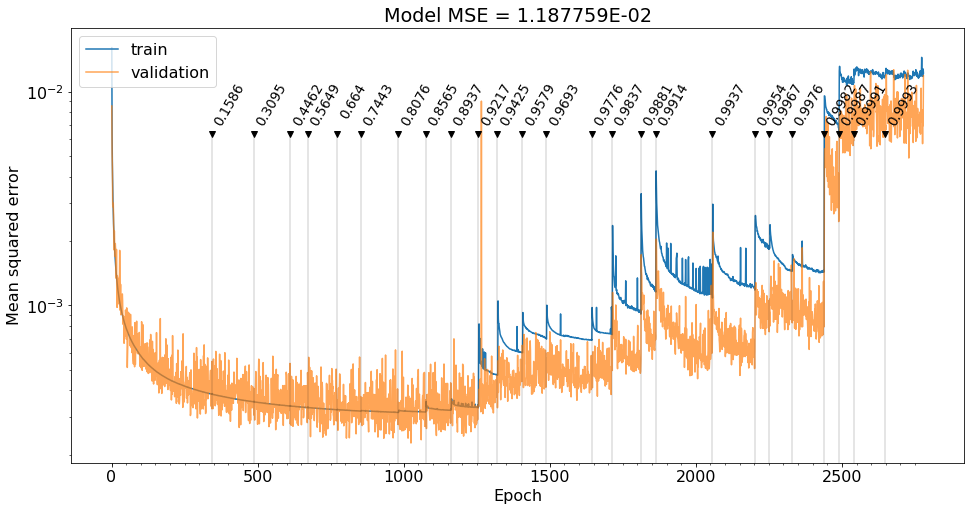

In [170]:
plot_model_history_fromDict(historyDict)

for i in range(len(cut_epochs)-1):
    plt.axvline(x=cut_epochs[i],ymax=0.75,color='k',linewidth=.2)
    plt.plot(cut_epochs[i],10**-2.2, "v", color = "black")
    
for i in range(0,len(cut_epochs)-1):
    plt.text(cut_epochs[i],0.01,round(cutPercent[i],4),rotation=60,fontsize='small')

## Figure Creation

Load both pruned models 

### Callin's Model

In [173]:
K.clear_session()

modeltimestamp = '2020_07_23__09_04_49'

# load history with same name as model
historyFile = '2020_07_23__09_04_49_CallinPruned_history.pkl'
modelSubdir = os.path.join(savedModels, modeltimestamp + "_checkpoints")
historyDict_CS_prune = pickle.load(open(os.path.join(modelSubdir, historyFile), 'rb'))

# load prune timestamps
# Callin's method for saving the pruning epochs
savedChecks = [f for f in os.listdir(os.path.join(savedModels, modelSubdir)) if f.endswith('wts.pkl')]
vlines = [int(savedChecks[ii][0:4].replace("_", "")) for ii in range(len(savedChecks)) if savedChecks[ii][0].isdigit()]

Text(150,0.00105,'Hypothetical noise threshold')

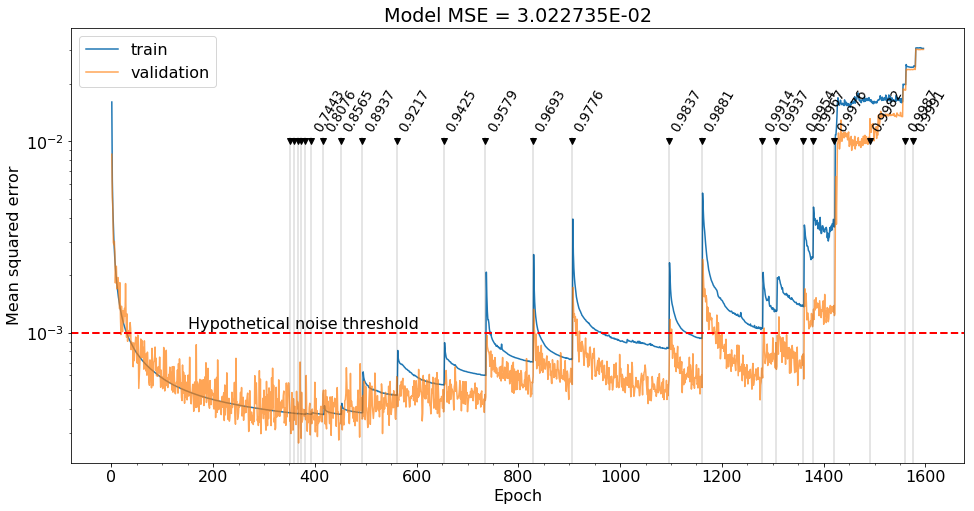

In [216]:
plot_model_history_fromDict(historyDict_CS_prune)

for i in range(len(vlines)-1):
    plt.axvline(x=vlines[i],ymax=0.75,color='k',linewidth=.2)
    plt.plot(vlines[i],10**-2, "v", color = "black")
    
vlines.sort()
    
for i in range(0,len(vlines)-1):
    if i > 4:
        plt.text(vlines[i],0.017,round(cutPercent[i],4),rotation=60,fontsize='small')
        
plt.axhline(0.001, linestyle= '--',linewidth=2, color='r')
plt.text(150, 0.00105, 'Hypothetical noise threshold')

In [189]:
modeltimestamp = "2020_07_23__09_04_49"


# load history with same name as model
historyFile = '2020_07_23__09_04_49_pruned_history.pkl'
historyDict_OT_prune = pickle.load(open(os.path.join(dataOutput, historyFile), 'rb'))

epochFile = '2020_07_23__09_04_49_pune_timestamps'
cut_epochs = pickle.load(open(os.path.join(dataOutput, epochFile), 'rb'))

Text(150,0.00105,'Hypothetical noise threshold')

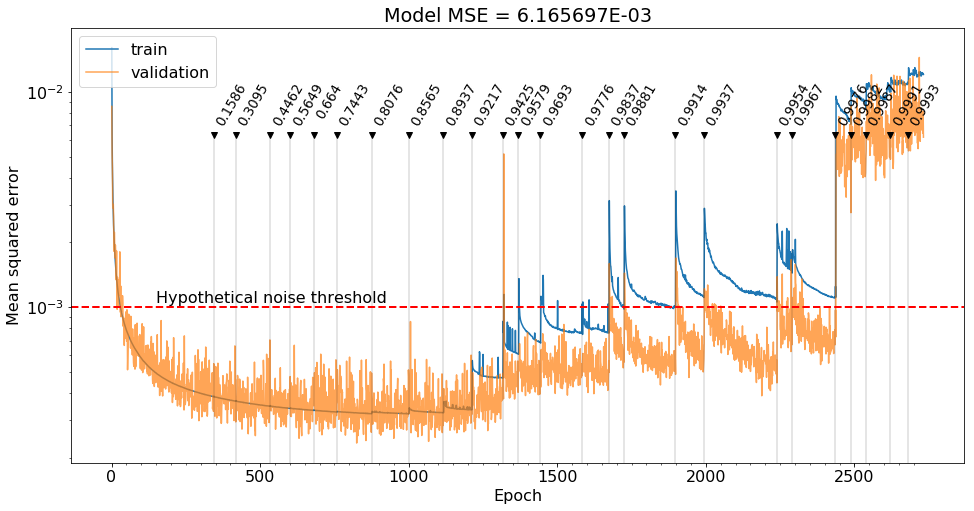

In [217]:
plot_model_history_fromDict(historyDict_OT_prune)

for i in range(len(cut_epochs)-1):
    plt.axvline(x=cut_epochs[i],ymax=0.75,color='k',linewidth=.2)
    plt.plot(cut_epochs[i],10**-2.2, "v", color = "black")
    
for i in range(0,len(cut_epochs)-1):
    plt.text(cut_epochs[i],0.01,round(cutPercent[i],4),rotation=60,fontsize='small')
    
plt.axhline(0.001, linestyle= '--',linewidth=2, color='r')
plt.text(150, 0.00105, 'Hypothetical noise threshold')

In [69]:
# predict on test set
Ytest_pred = model.predict(Xtest_scaled)


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = Xtrain.columns)
YtestDF = pd.DataFrame(Ytest, columns = Ytrain.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Ytrain.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,Fx_pred,Fy_pred,tau_pred,x_dot_99_pred,y_dot_99_pred,phi_dot_99_pred,theta_dot_99_pred
0,-5342.432439,14670.842555,-57718.558932,-577.070011,-1317.410003,-76.817401,-84.515766,-5967.453613,17690.990234,-48919.882812,-580.231506,-1343.035034,-114.036430,-118.226456
1,-2515.747661,3418.036434,-64775.342625,-18.839022,1292.672193,17.808851,1.199298,-5309.352539,5041.308105,-60412.925781,-1.199094,1383.986938,-4.115515,-8.734145
2,-6497.950980,-17669.503572,-49237.798014,-1094.713883,-1469.532303,124.939700,115.462788,-10475.754883,-16107.546875,-47557.539062,-1136.972900,-1391.377197,144.275894,139.078659
3,24237.433019,-8489.629561,56490.932254,-187.441953,-427.573908,100.329900,100.827942,22148.250000,-6499.242676,67265.007812,-273.286438,-550.424805,135.582123,130.418793
4,1782.839206,5791.542006,26503.920442,625.069923,31.217768,-26.216617,-20.827598,3927.504150,6896.766113,32134.501953,647.107727,-55.471333,9.455336,4.783791


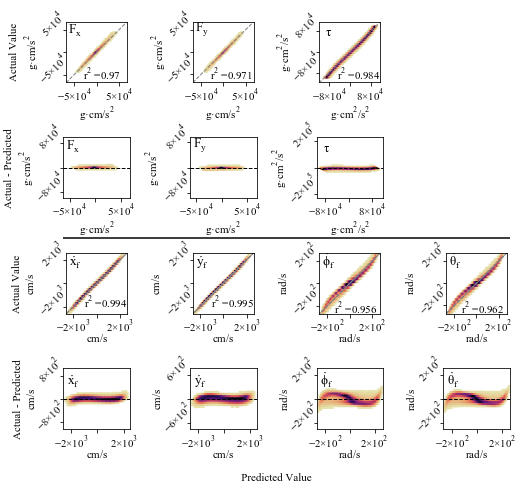

In [70]:
# make plots
from sklearn.metrics import r2_score
from matplotlib import ticker
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.default'] = 'regular'
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 11})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.transforms as mtrans


fig_col_names = [r'$F_x$', r'$F_y$', r'$\tau$', r'$\dot{x}_f$', r'$\dot{y}_f$', r'$\dot{\phi}_f$', r'$\dot{\theta}_f$']

plt.close("all")
fig, axs = plt.subplots(4,4, figsize=np.array([8, 7.5]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.9, wspace=.9)
# fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r'$g·cm/s^2$', "$g·cm/s^2$", "$g·cm^2/s^2$", "$cm/s$", "$cm/s$", "$rad/s$", "$rad/s$"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
# make really low-value hexbins white
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii in np.arange(0, 3):
    axs[ii].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[ii].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].set_yticklabels(axs[ii].get_yticklabels(), 
                            rotation = 45, ha="center",
                            va = "bottom", rotation_mode="anchor")
    axs[ii].yaxis.set_label_coords(-0.4,0.5)
    axs[ii].set_xlabel(ylabs[ii] + "\n")
    axs[ii].xaxis.set_label_coords(0.5,-0.3)
    axs[ii].tick_params(axis="x",direction="out", pad=-0)
    

    if(ii == 0):
        axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
    else:
        axs[ii].set_ylabel(ylabs[ii])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[ii].set_title(fig_col_names[ii], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[ii].title
    ttl.set_position([.15, 0.62])
    
    # draw identity lines
    lims = [
        np.min([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # min of both axes
        np.max([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # max of both axes
        ]
    axs[ii].plot(lims, lims,  
                 'grey', linewidth = 1, linestyle  = "--")
#     axs[ii].plot(df_c.loc[:,YtestDF.columns[ii]], 
#                  df_c.loc[:,YtestDF.columns[ii]], 
#                  'grey', linewidth = 1, linestyle  = "--")
    axs[ii].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].set_aspect('equal', 'box')

    # annotate with R^2
    axs[ii].text(np.max(lims)*-0.4, 
                 np.min(lims)*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[ii].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])
    axs[ii].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(4, 7)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.3)
    
    if jj == 3:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                      Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 0):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])
        
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.62])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
#####
#### Part 2
#####

#fig.subplots_adjust(hspace = 0.9, wspace=.9)

# Plot y = actual, x = predicted
for plotnum, dataColNum in zip(np.arange(8,12), np.arange(3, 7)):
    axs[plotnum].hexbin(y = df_c.loc[:,YtestDF.columns[dataColNum]],
                   x = df_c.loc[:,YpredDF.columns[dataColNum]], 
                   gridsize = 50, cmap = cmap)
    axs[plotnum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].set_yticklabels(axs[plotnum].get_yticklabels(),
                                 rotation = 45, ha="center",
                                 va = "bottom", rotation_mode="anchor")
    axs[plotnum].yaxis.set_label_coords(-0.5,0.5)
    axs[plotnum].set_xlabel(ylabs[dataColNum] + "\n")
    axs[plotnum].xaxis.set_label_coords(0.5,-0.3)

    if(plotnum == 8):
        axs[plotnum].set_ylabel("Actual Value\n" + ylabs[dataColNum])
    else:
        axs[plotnum].set_ylabel(ylabs[dataColNum])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[plotnum].set_title(fig_col_names[dataColNum], 
                           fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotnum].title
    ttl.set_position([.15, 0.60])
    axs[plotnum].plot(df_c.loc[:,YtestDF.columns[dataColNum]], 
                 df_c.loc[:,YtestDF.columns[dataColNum]], 
                 'grey', linewidth = 1, linestyle  = "--")
    axs[plotnum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].set_aspect('equal', 'box')

    # annotate with R^2
    axs[plotnum].text(np.max(df_c.loc[:,YtestDF.columns[dataColNum]])*-0.4, 
                 np.min(df_c.loc[:,YtestDF.columns[dataColNum]])*0.75, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[dataColNum]],  
                                        df_c.loc[:,YpredDF.columns[dataColNum]])), 3)))
    axs[plotnum].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    axs[plotnum].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    
    axs[plotnum].tick_params(axis="x",direction="out", pad=-0)

# residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
# refref Here
for jj, plotNum in zip(np.arange(3, 7), np.arange(12, 16)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.3)############################
    
    if jj == 4:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                                       Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 3):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.55])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
    
axs[3].axis('off')
axs[7].axis('off')

# add black horizontal line
ax3 = plt.figure(1).add_subplot(111)
ax3.plot([-1,1],[0.47,0.47], '-', color = "black" )
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.axis("off")

#plt.tight_layout()
fig.savefig(os.path.join(figDir, "PredVActual" + modelName + "PRUNED.pdf"),)
plt.show()
# plt.close()